In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 25)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from db_queries import get_population

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data/'

In [4]:
binned_risks_ldl = pd.read_csv(sim_results_dir + 'binned_ldl_exposure_time.csv')
binned_risks_ldl = binned_risks_ldl.loc[(binned_risks_ldl.year == 2040)]
binned_risks_ldl = binned_risks_ldl.groupby(['input_draw','scenario', 'binned_ldl_limits', 'location']).value.sum().reset_index()
binned_risks_ldl = binned_risks_ldl.groupby(['scenario', 'binned_ldl_limits', 'location']).value.mean().reset_index()
binned_risks_ldl.head()

scenario binned_ldl_limits    location        value
0  baseline        above_4.91     alabama   903.596988
1  baseline        above_4.91      alaska  1023.814921
2  baseline        above_4.91     arizona   932.060780
3  baseline        above_4.91    arkansas   910.573032
4  baseline        above_4.91  california   958.201780

In [5]:
binned_risks_sbp = pd.read_csv(sim_results_dir + 'binned_sbp_exposure_time.csv')
binned_risks_sbp = binned_risks_sbp.loc[(binned_risks_sbp.year == 2040)]
binned_risks_sbp = binned_risks_sbp.groupby(['input_draw','scenario', 'binned_sbp_limits', 'location']).value.sum().reset_index()
binned_risks_sbp = binned_risks_sbp.groupby(['scenario', 'binned_sbp_limits', 'location']).value.mean().reset_index()
binned_risks_sbp.head()

scenario binned_sbp_limits    location        value
0  baseline         above_140     alabama  5844.138535
1  baseline         above_140      alaska  5638.467899
2  baseline         above_140     arizona  5561.861739
3  baseline         above_140    arkansas  5577.163039
4  baseline         above_140  california  6166.217112

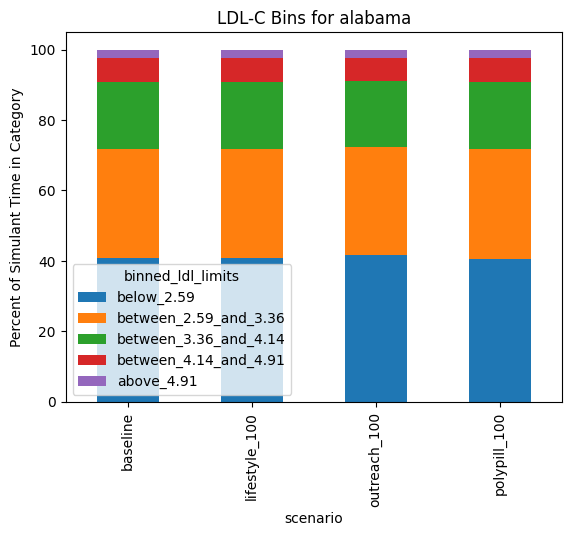

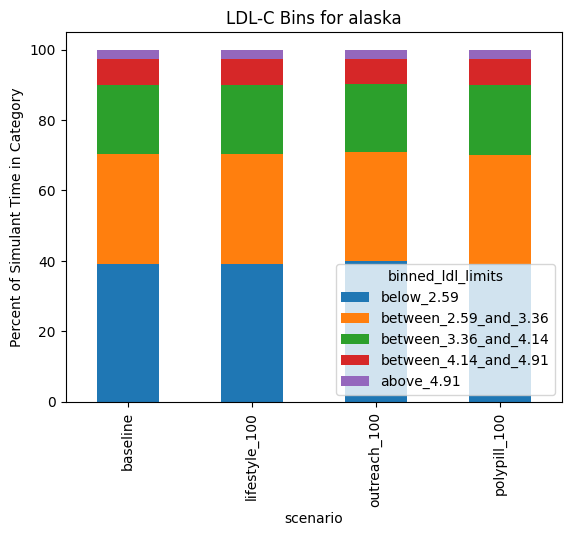

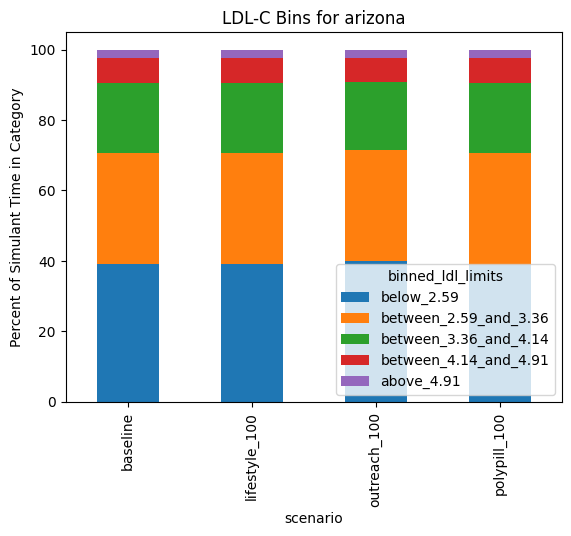

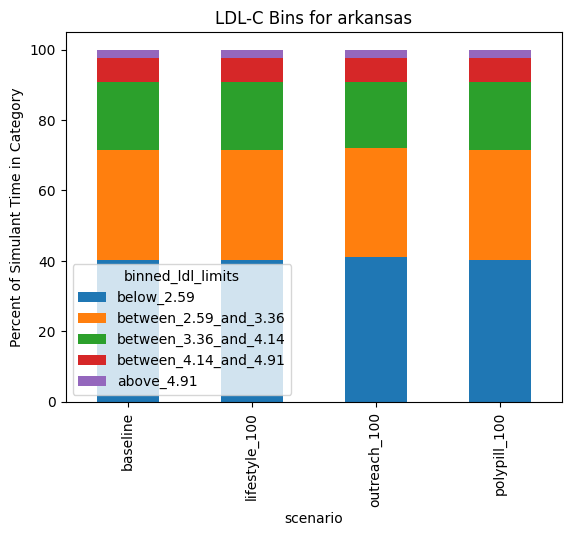

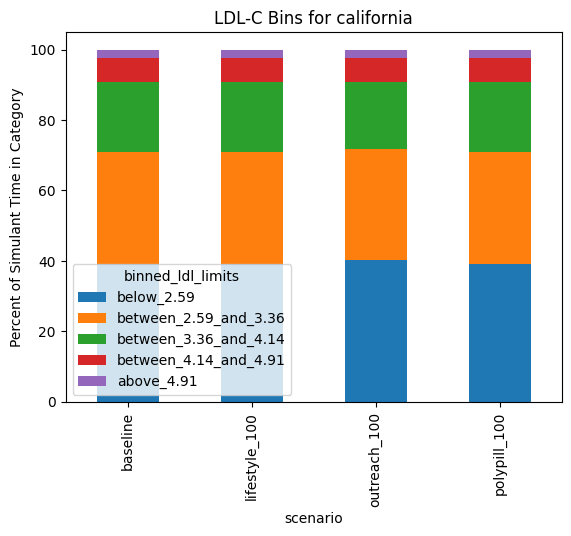

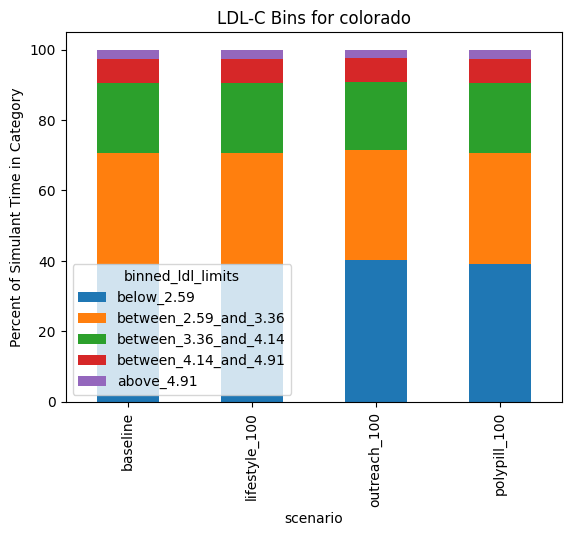

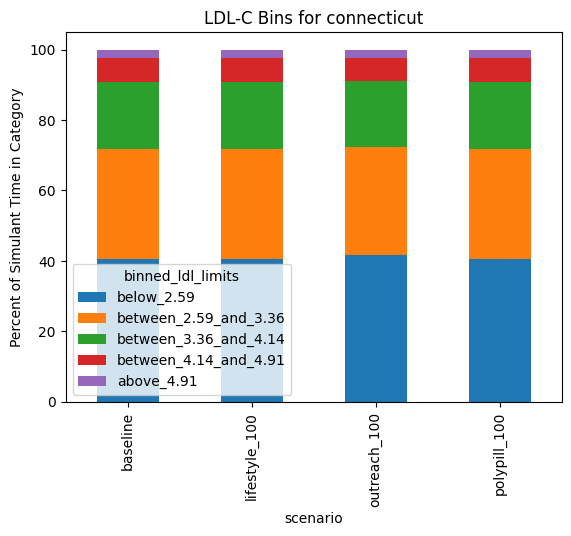

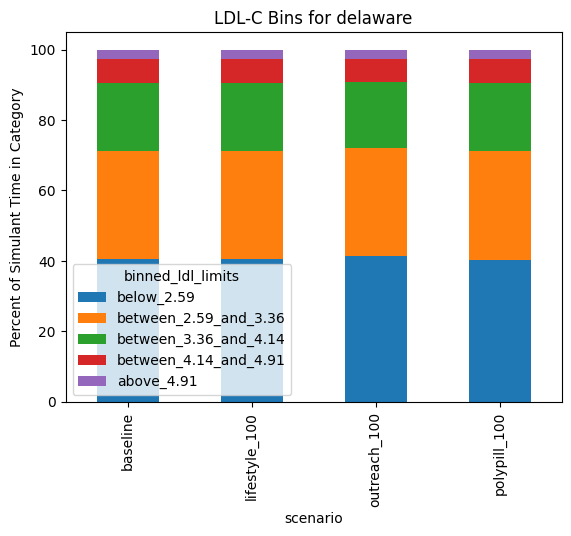

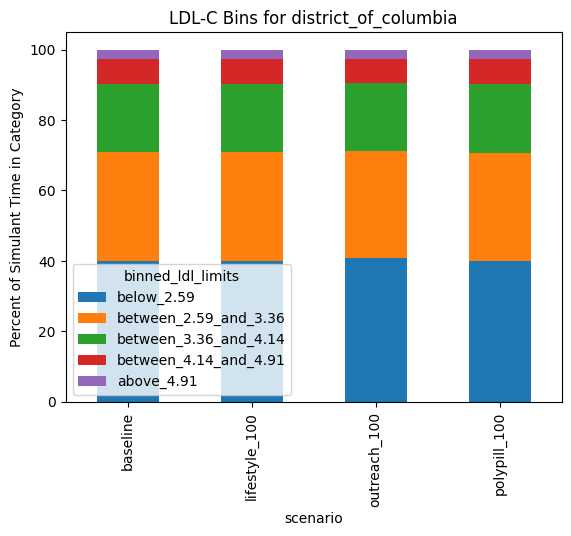

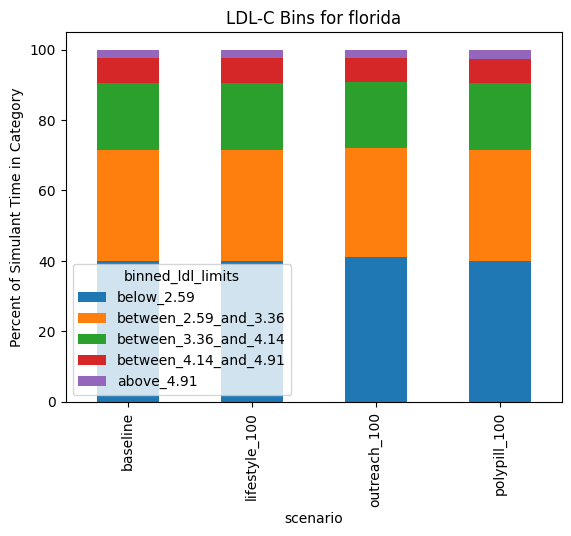

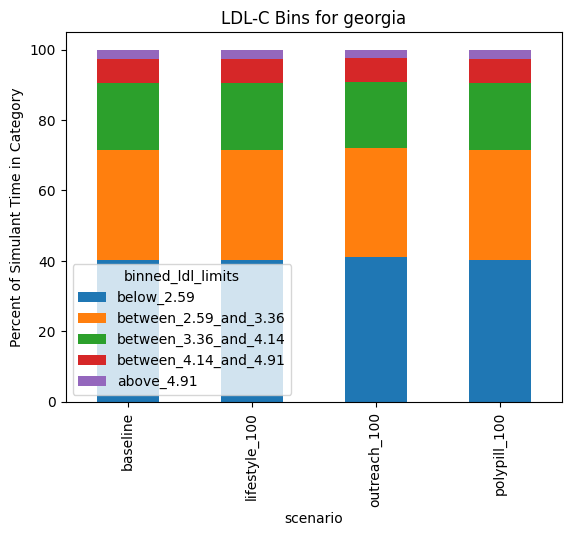

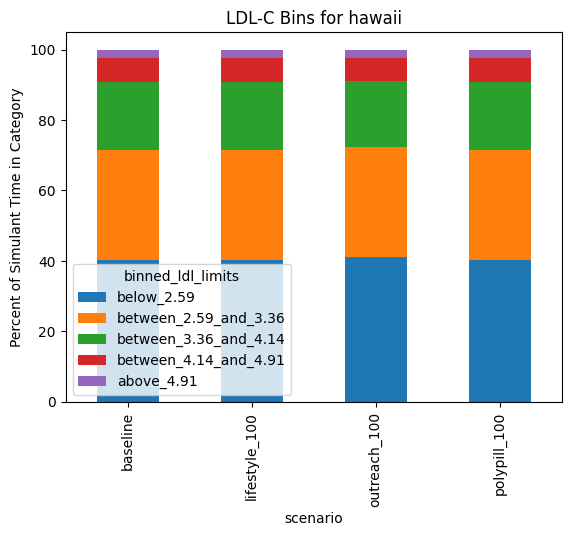

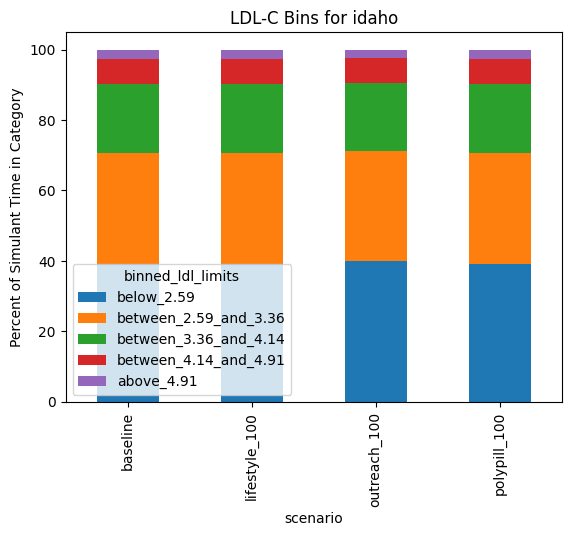

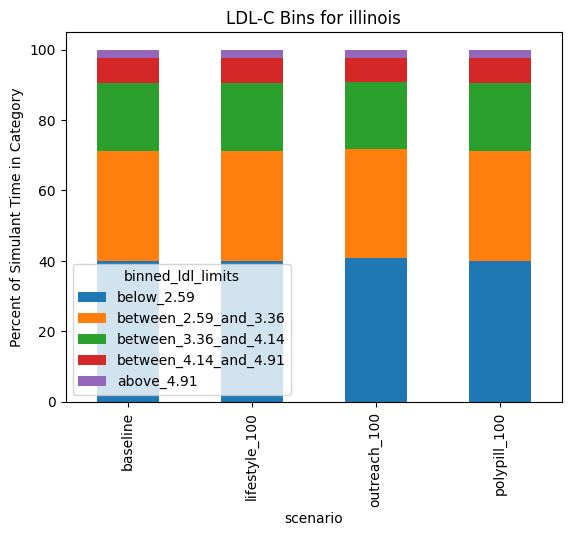

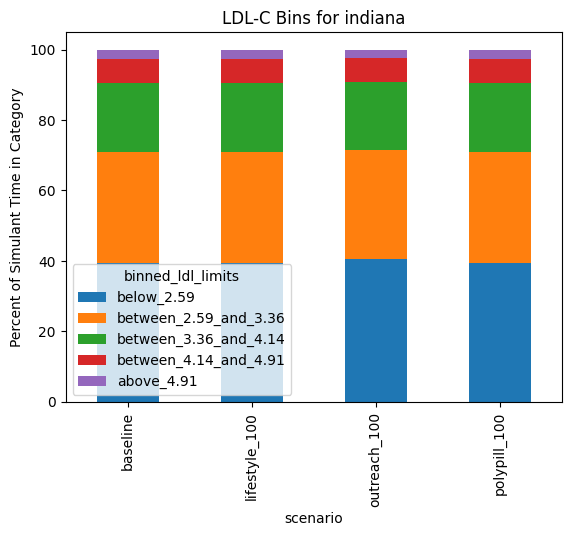

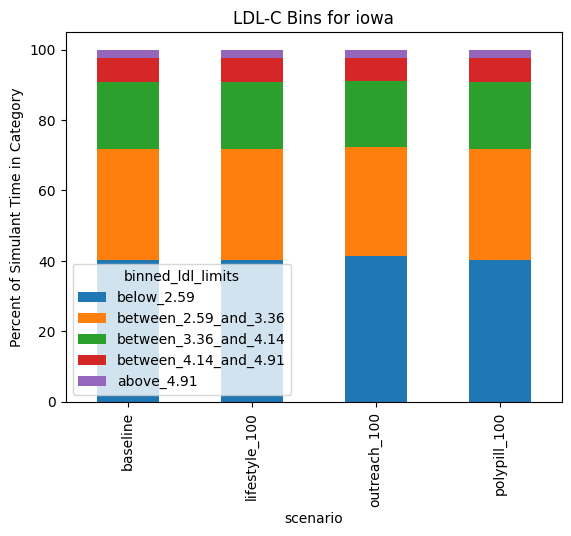

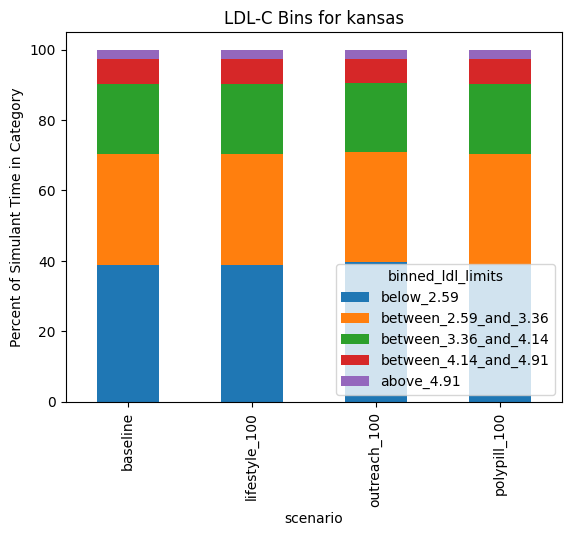

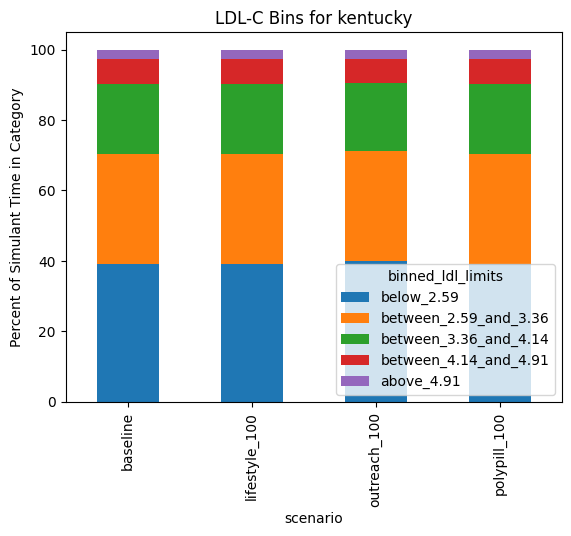

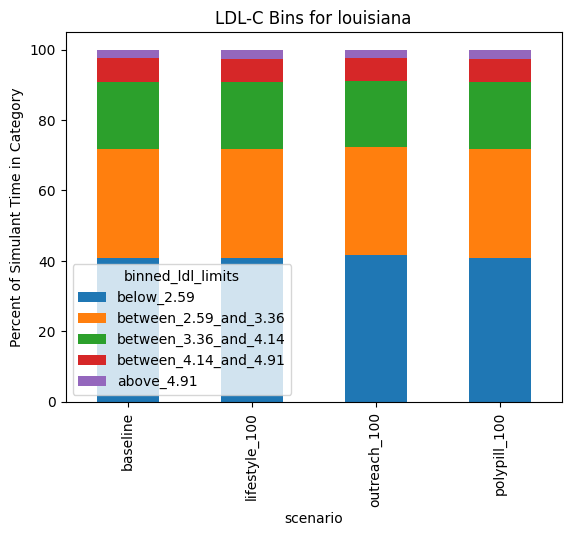

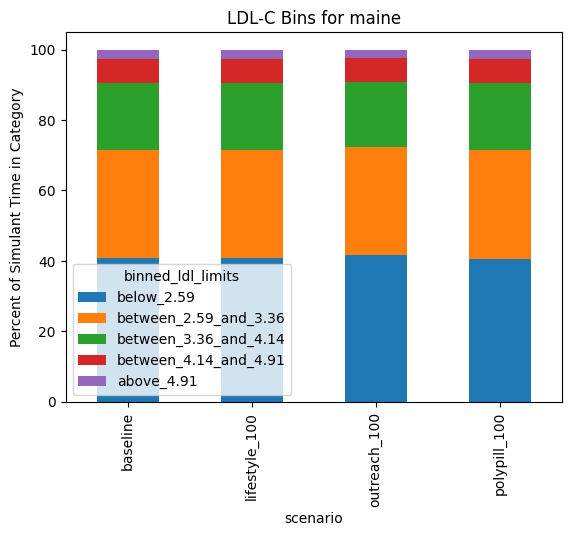

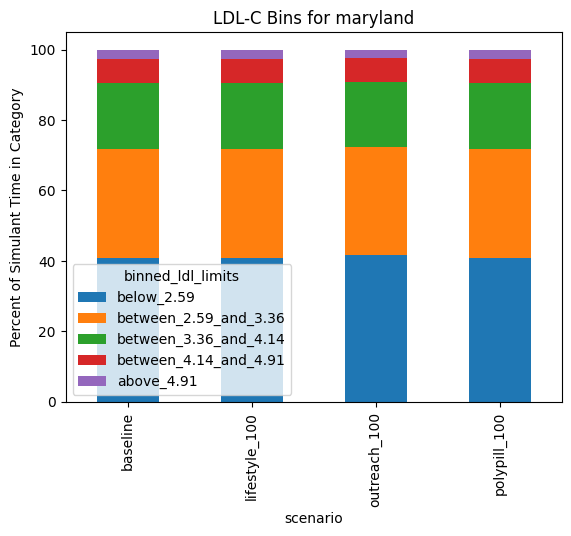

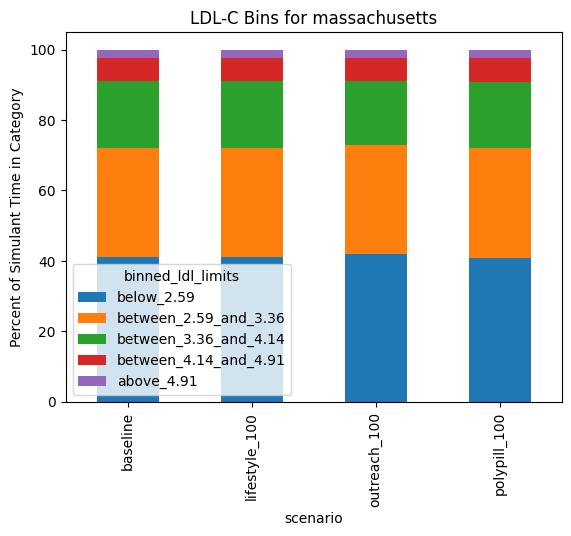

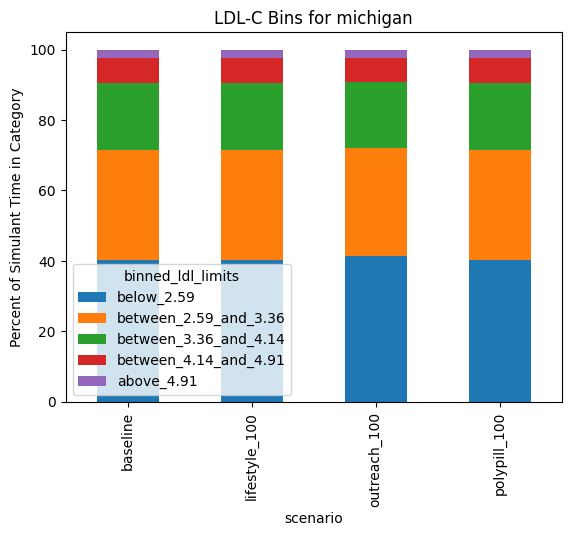

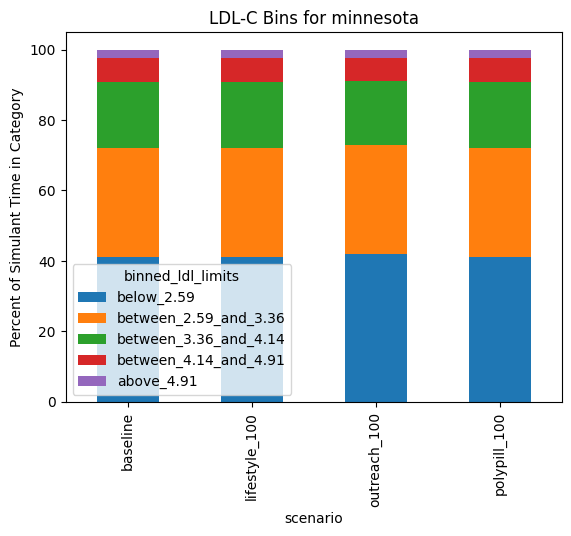

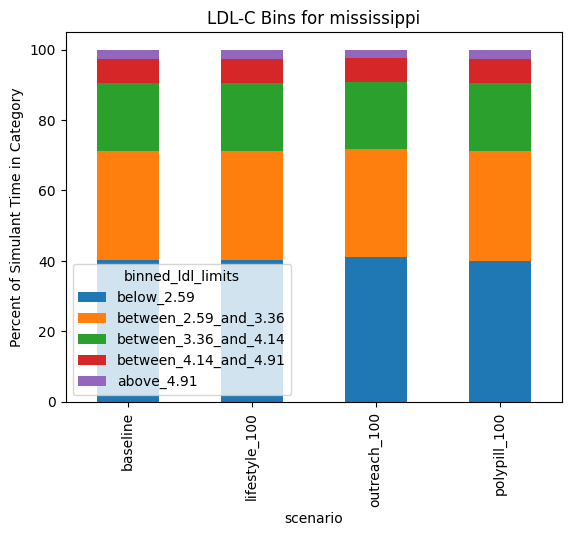

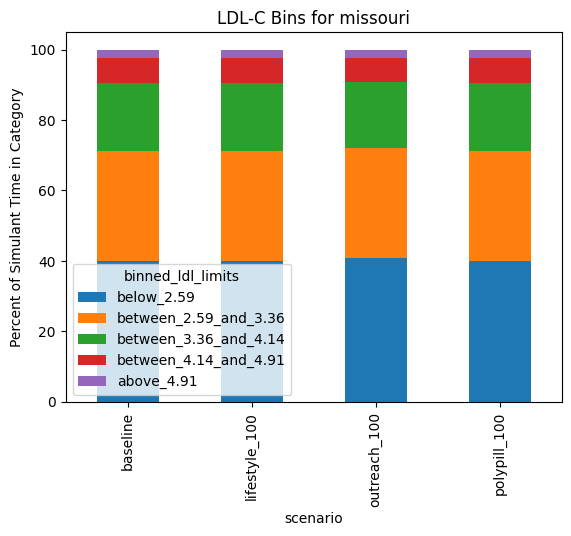

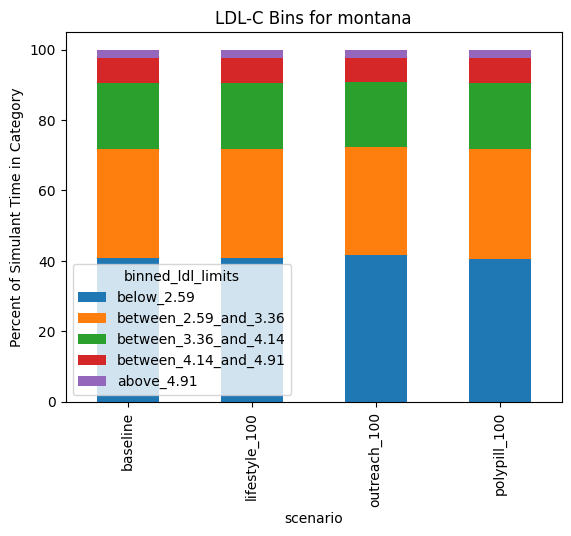

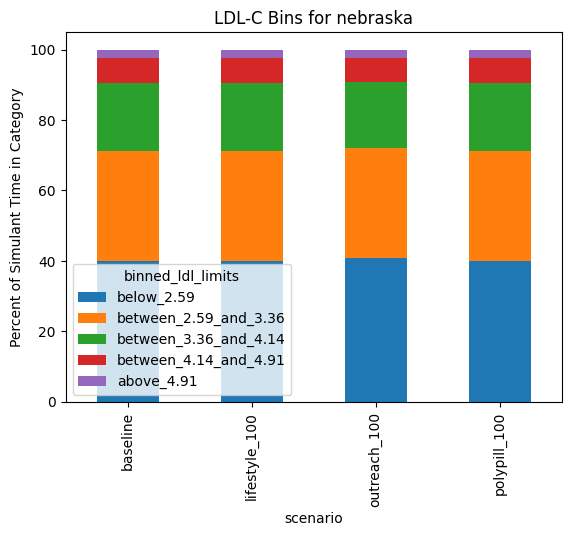

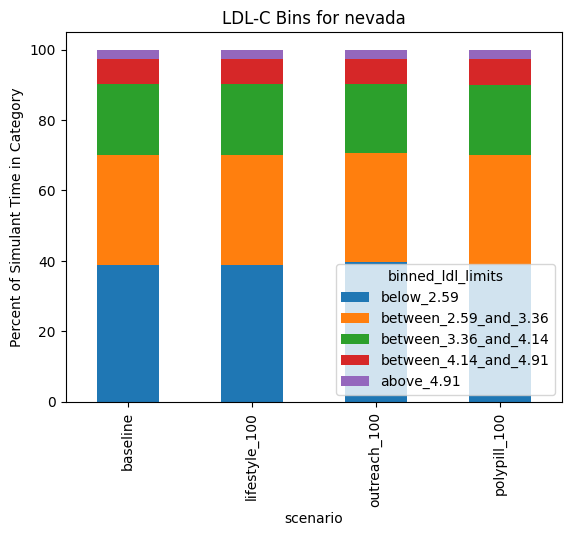

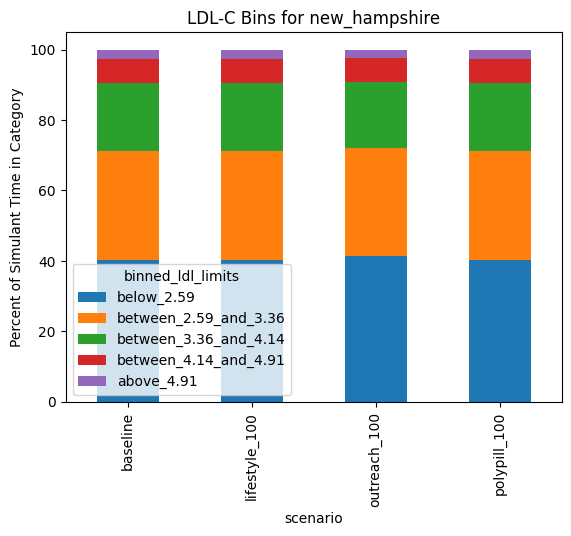

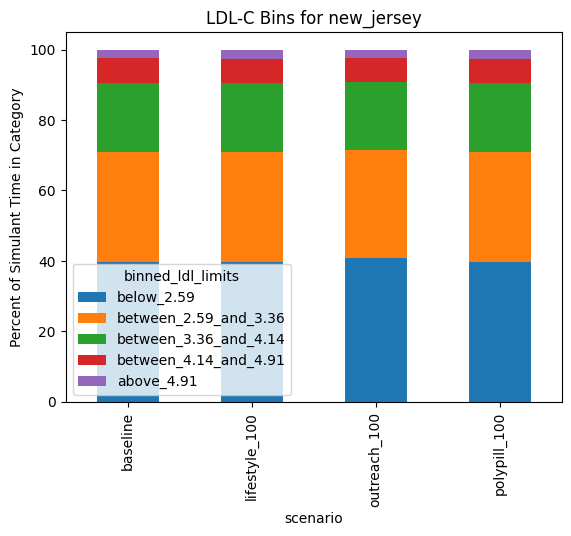

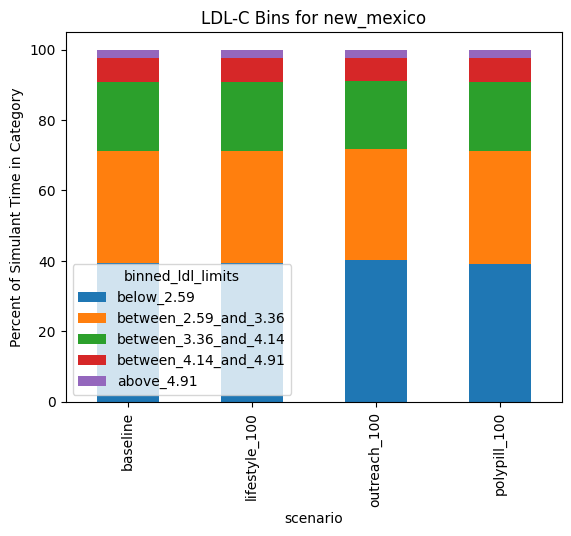

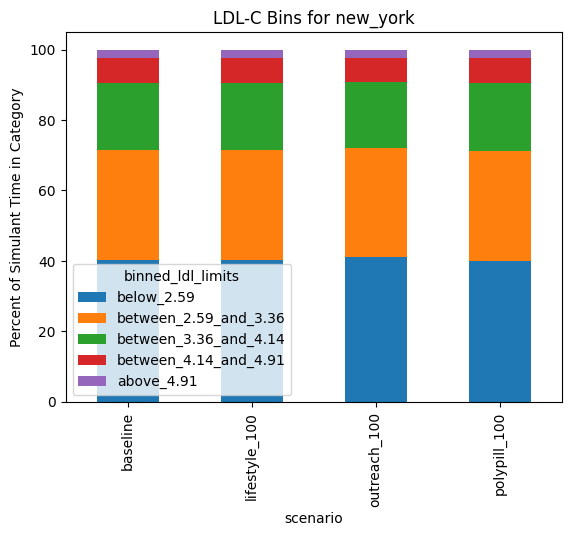

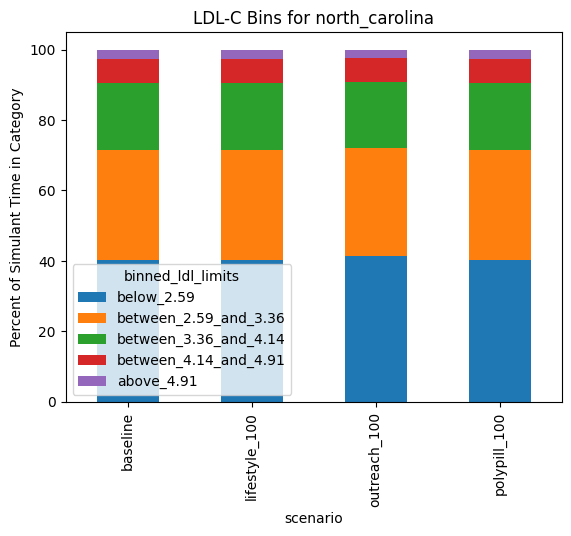

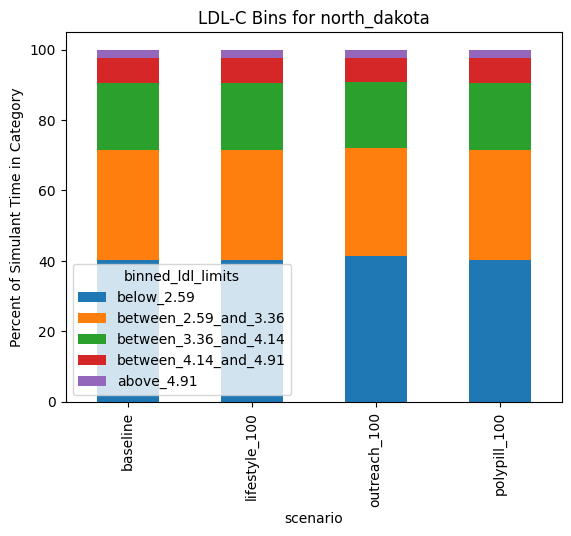

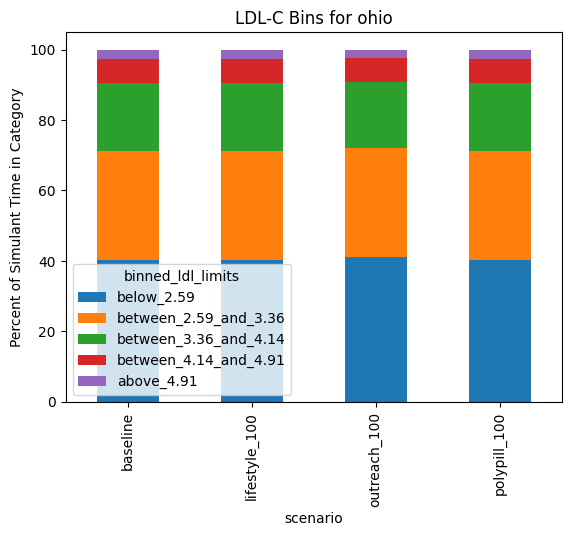

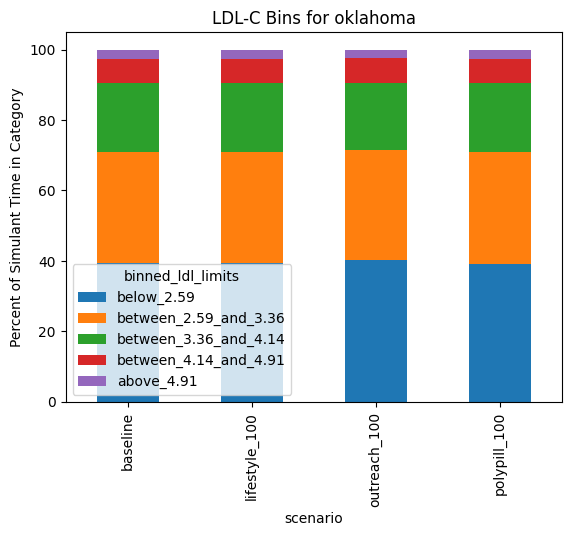

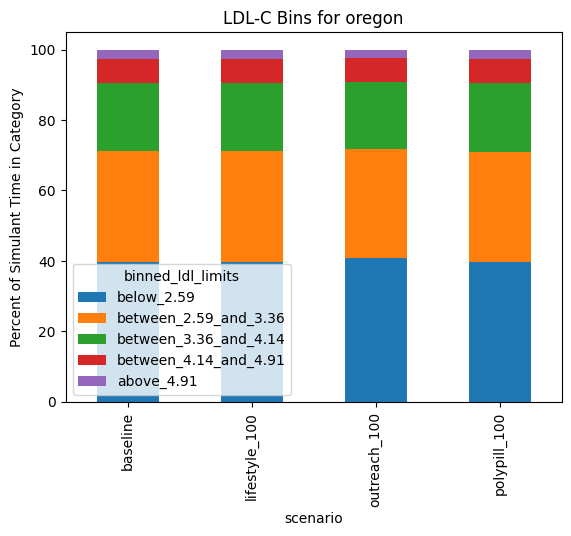

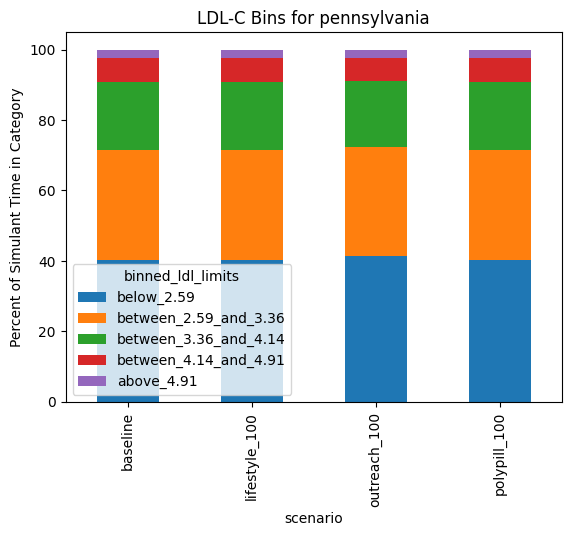

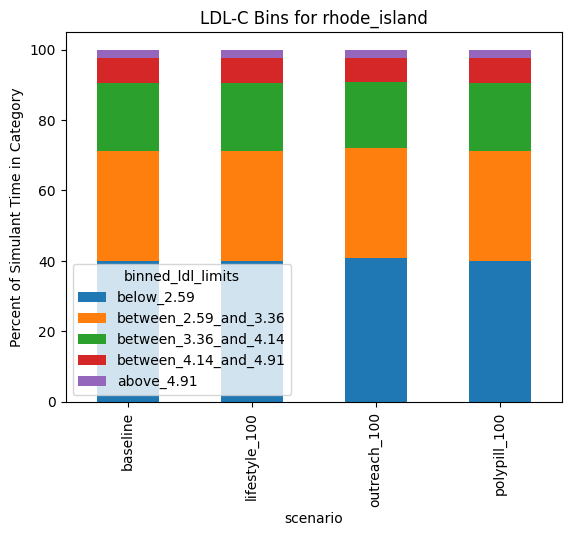

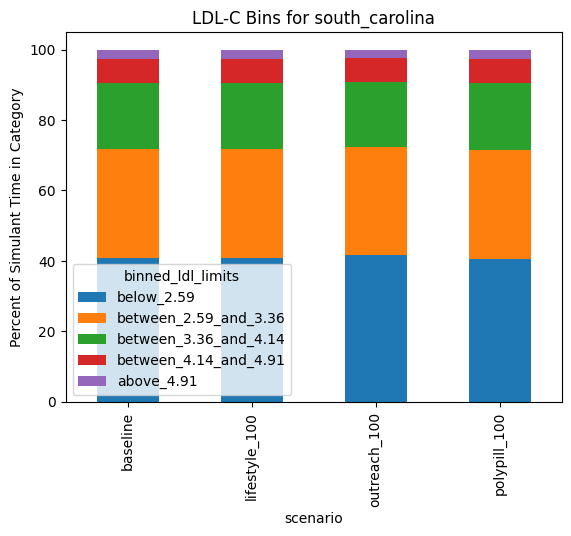

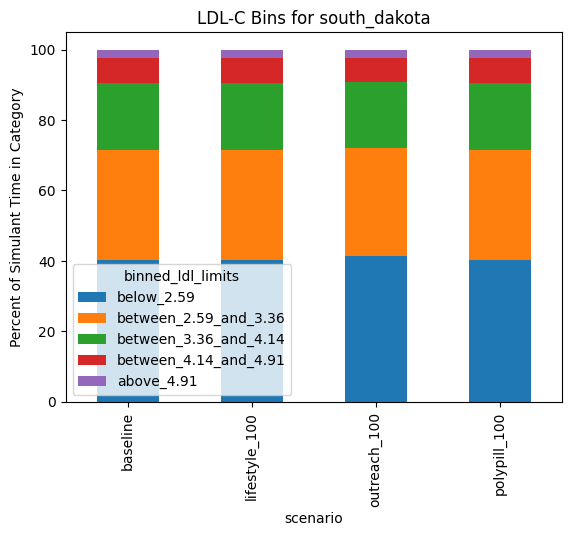

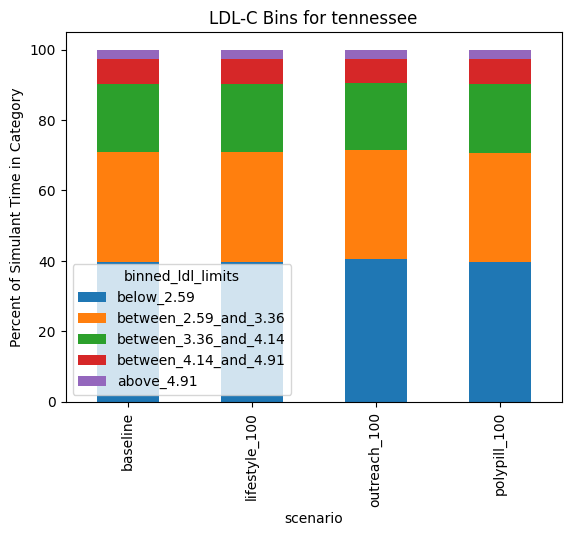

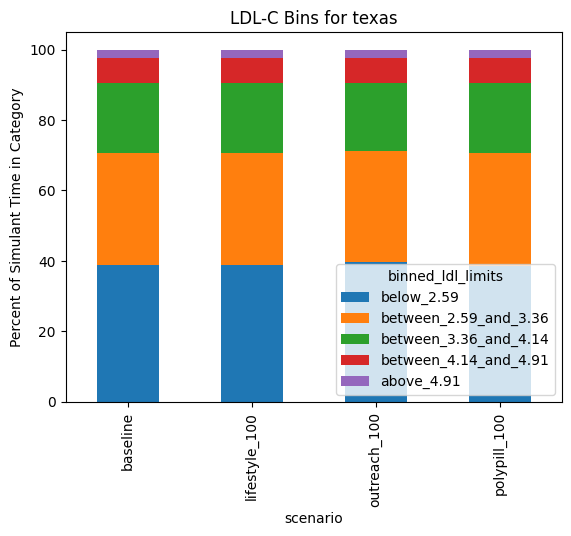

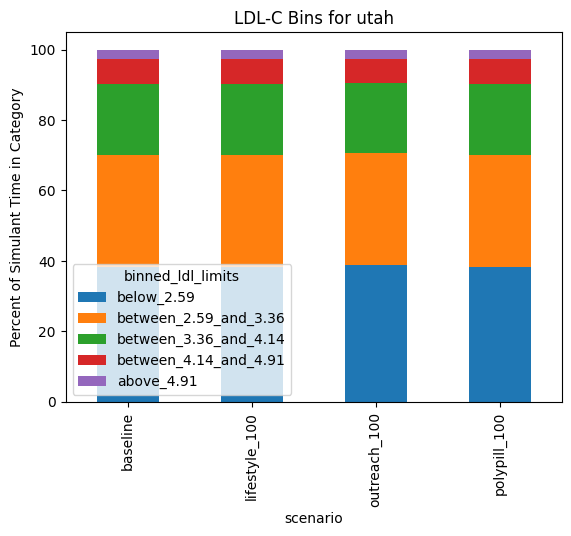

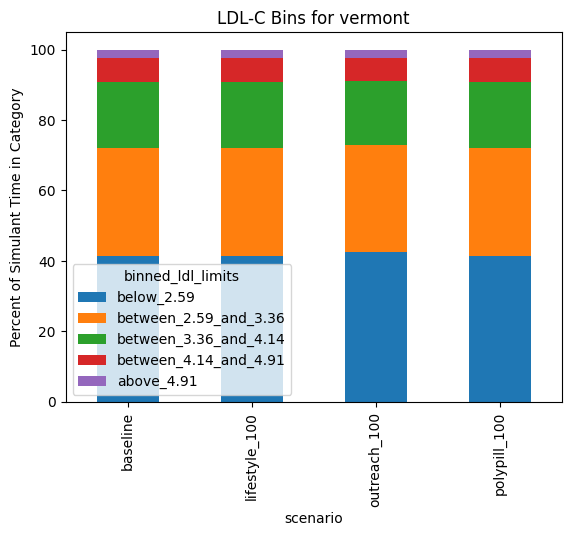

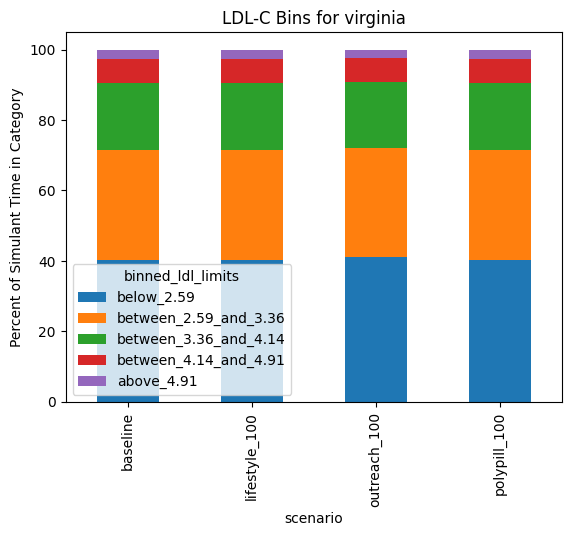

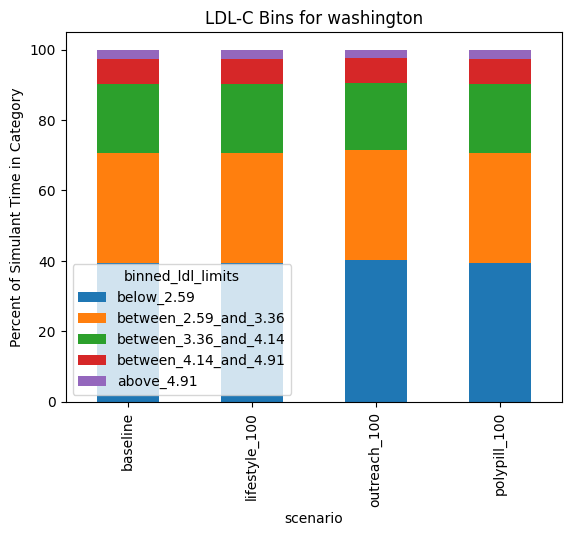

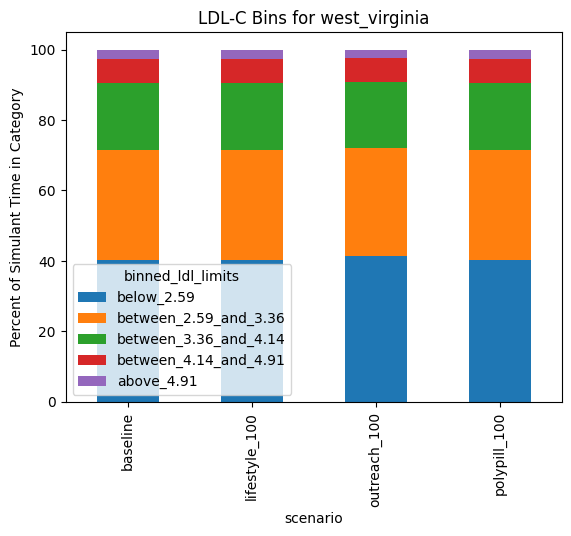

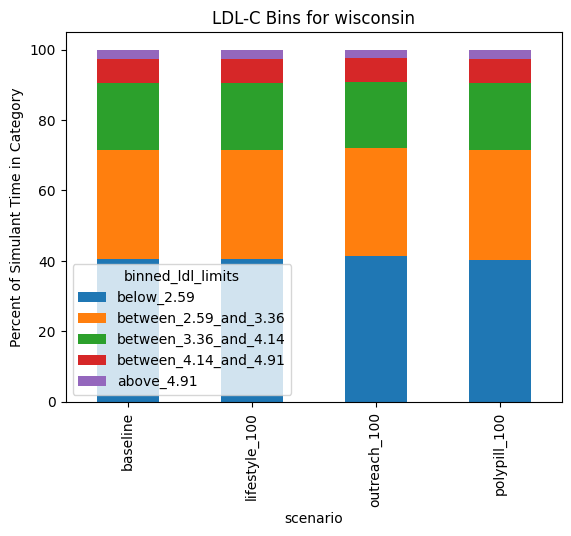

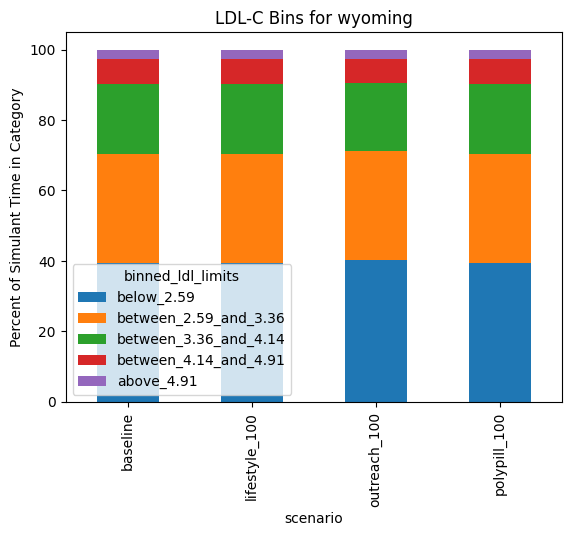

In [10]:
# Plotting
with PdfPages('ldl_binned_risks_8_31_23.pdf') as pdf:
    for location in binned_risks_ldl.location.unique():
        subdata = binned_risks_ldl.loc[binned_risks_ldl.location == location]
        pivot_df = subdata.pivot(index='scenario', columns='binned_ldl_limits', values='value')

        column_order = ['below_2.59', 'between_2.59_and_3.36', 'between_3.36_and_4.14', 'between_4.14_and_4.91', 'above_4.91']
        pivot_df = pivot_df[column_order]

        # Calculate the total for each category
        totals = [a+b+c+d+e for a,b,c,d,e in zip(pivot_df['below_2.59'], pivot_df['between_2.59_and_3.36'], pivot_df['between_3.36_and_4.14'], pivot_df['between_4.14_and_4.91'], pivot_df['above_4.91'])]

        # Normalize the data to make each category sum to 100%
        pivot_df['below_2.59'] = [a/total*100 for a,total in zip(pivot_df['below_2.59'], totals)]
        pivot_df['between_2.59_and_3.36'] = [b/total*100 for b,total in zip(pivot_df['between_2.59_and_3.36'], totals)]
        pivot_df['between_3.36_and_4.14'] = [c/total*100 for c,total in zip(pivot_df['between_3.36_and_4.14'], totals)]
        pivot_df['between_4.14_and_4.91'] = [d/total*100 for d,total in zip(pivot_df['between_4.14_and_4.91'], totals)]
        pivot_df['above_4.91'] = [e/total*100 for e,total in zip(pivot_df['above_4.91'], totals)]

        fig, ax = plt.subplots()

        pivot_df.plot(kind='bar', stacked=True, ax=ax)

        ax.set_ylabel('Percent of Simulant Time in Category')
        ax.set_title(f'LDL-C Bins for {location}')

        #plt.show()
        pdf.savefig(bbox_inches='tight')

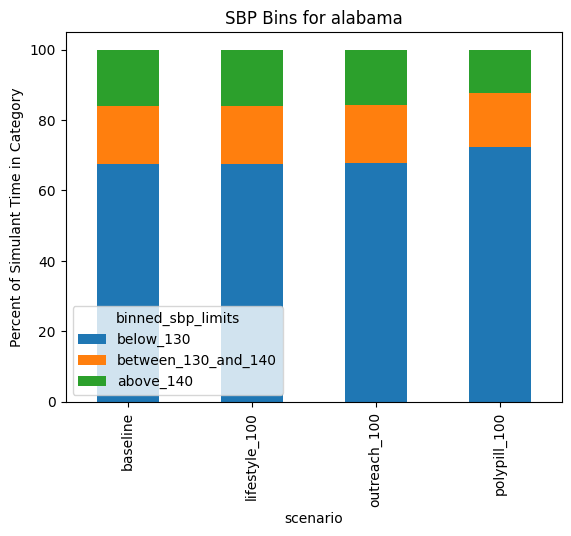

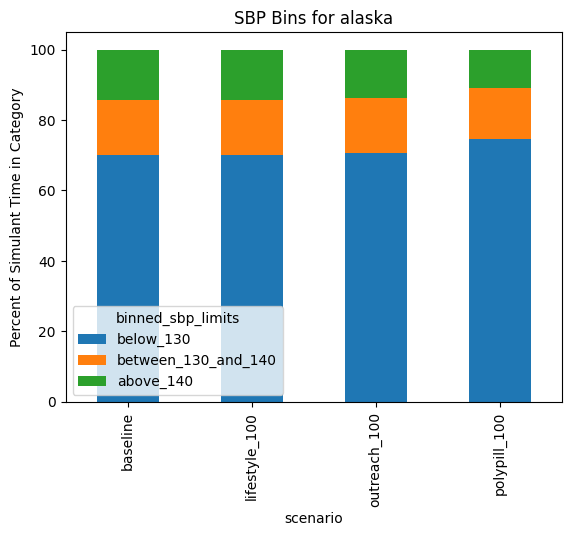

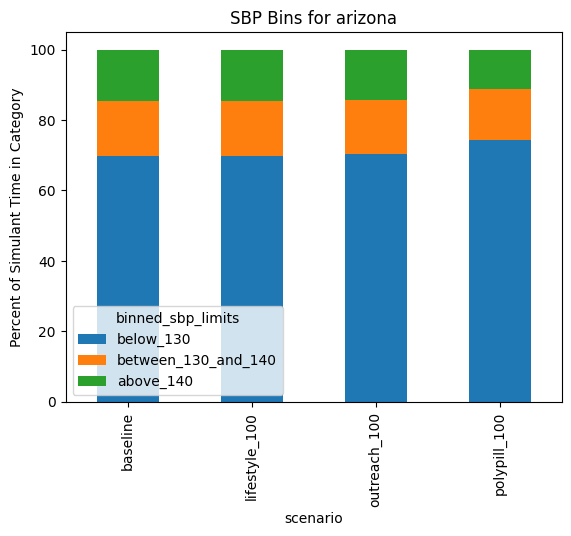

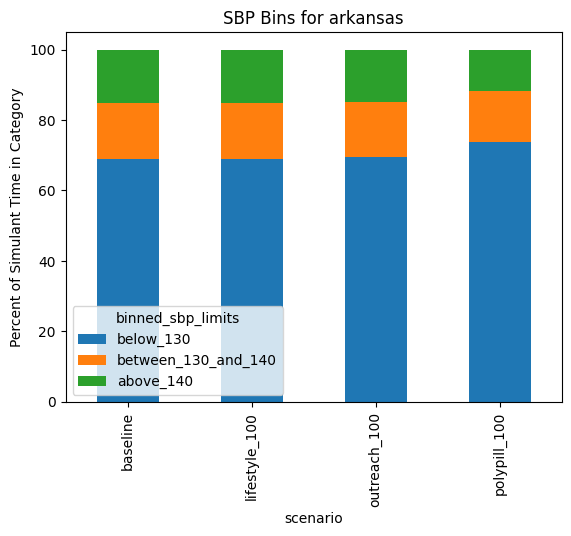

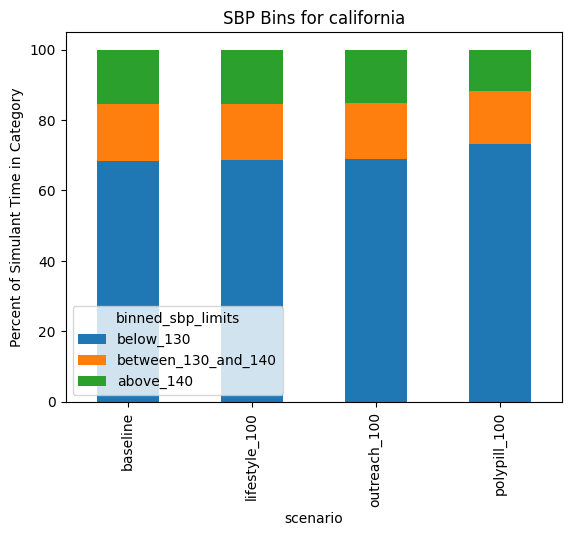

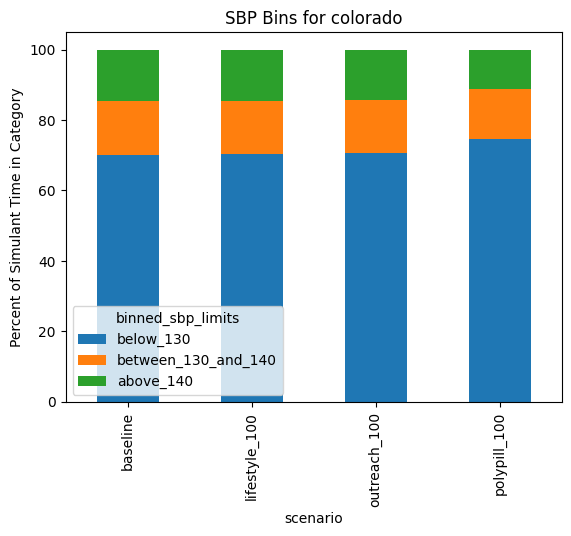

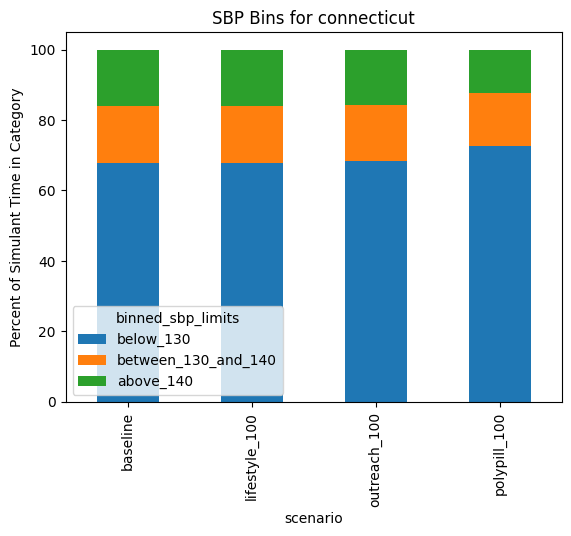

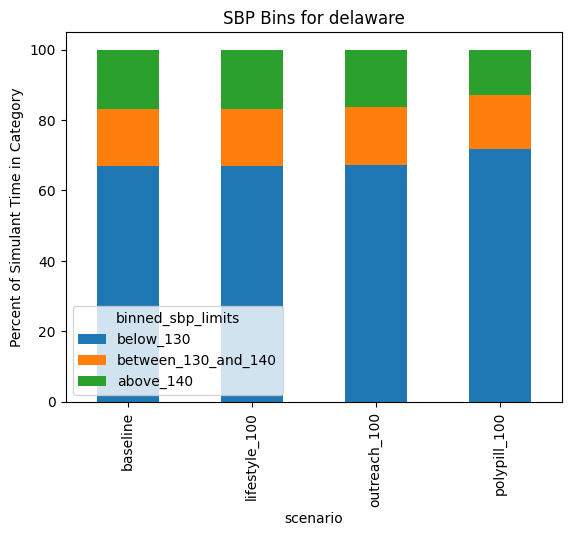

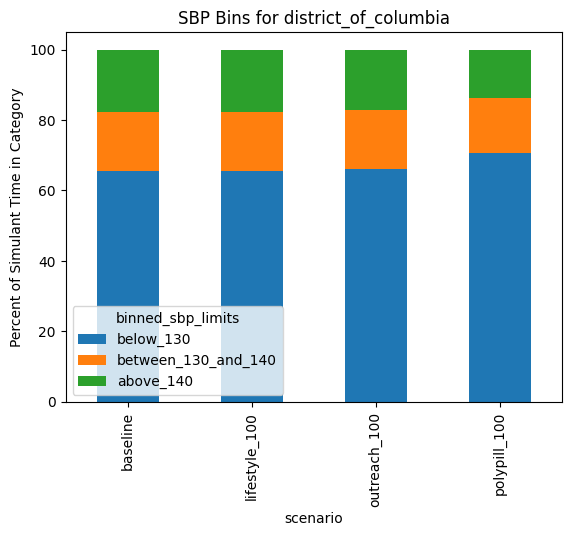

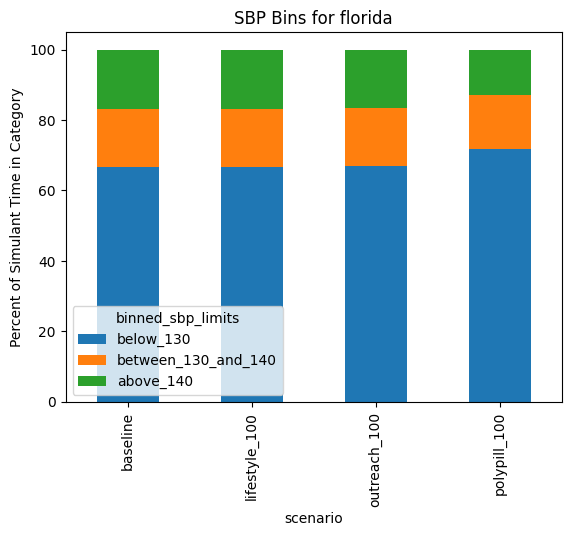

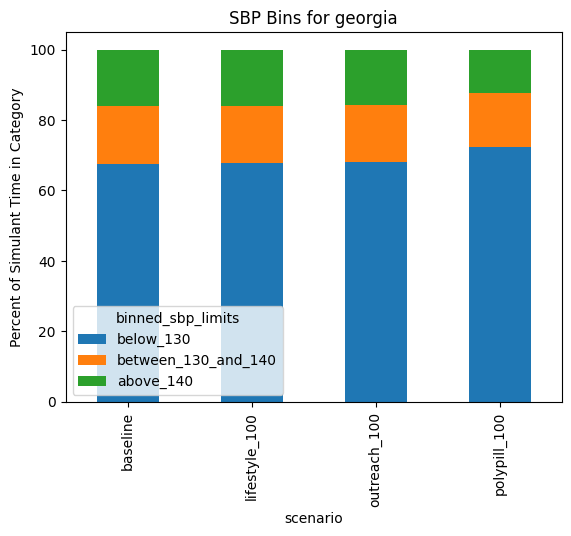

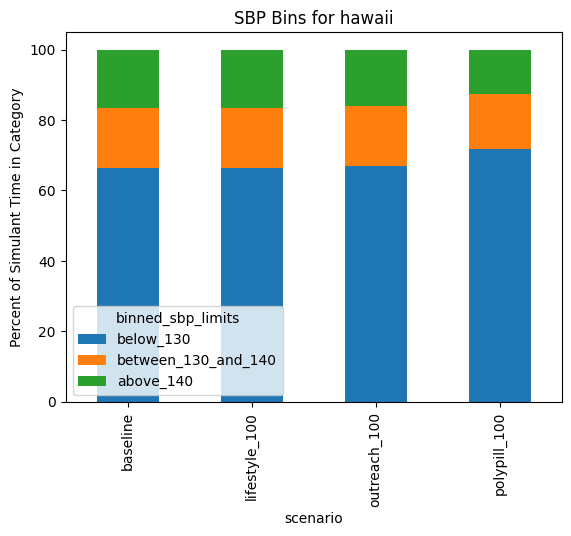

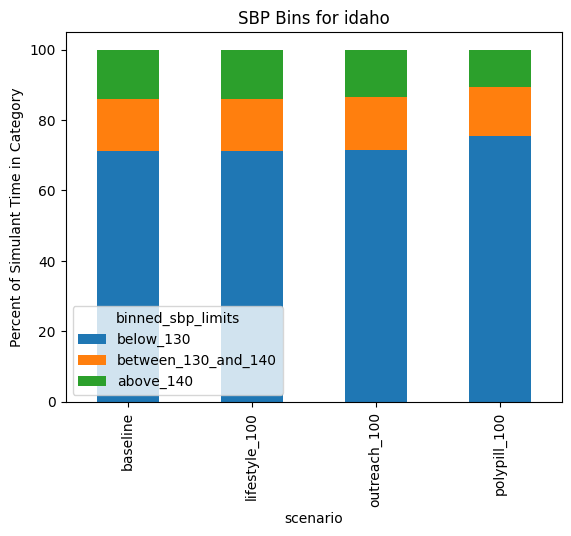

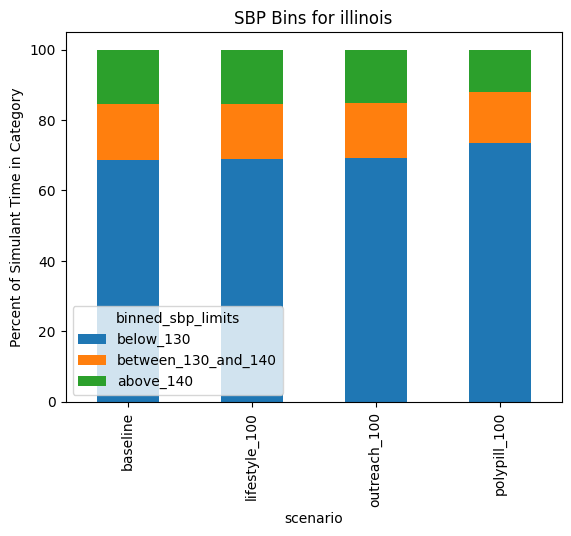

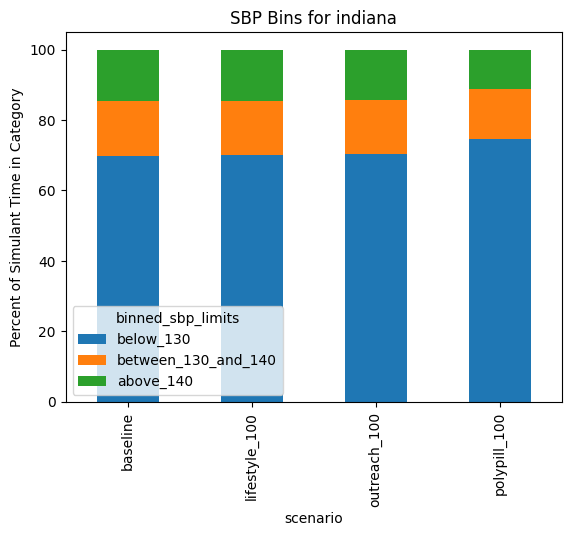

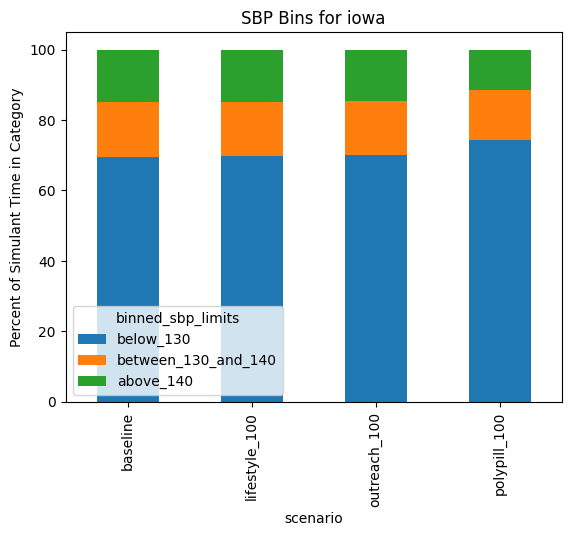

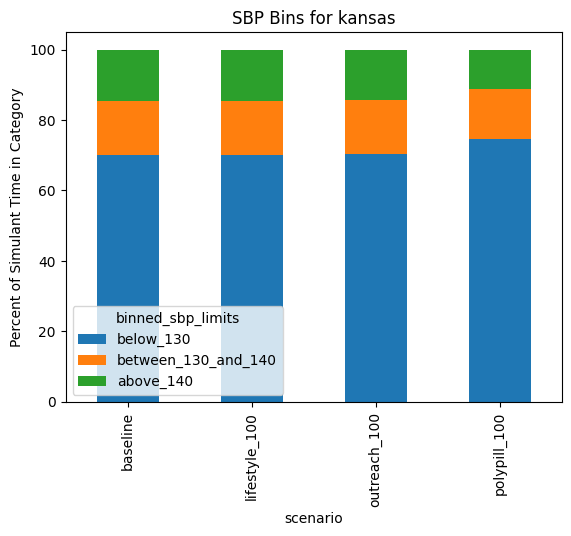

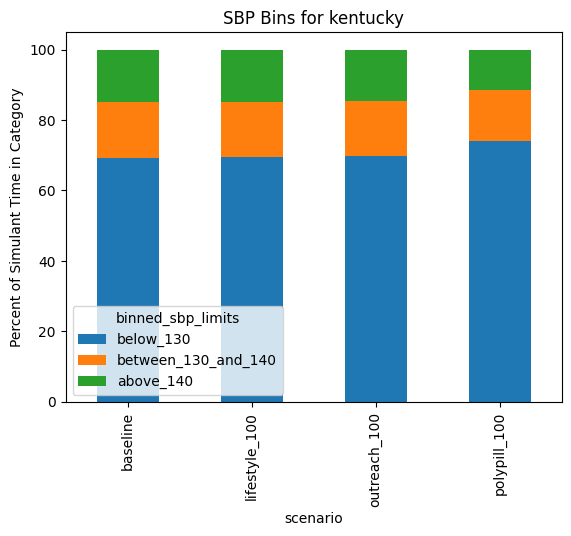

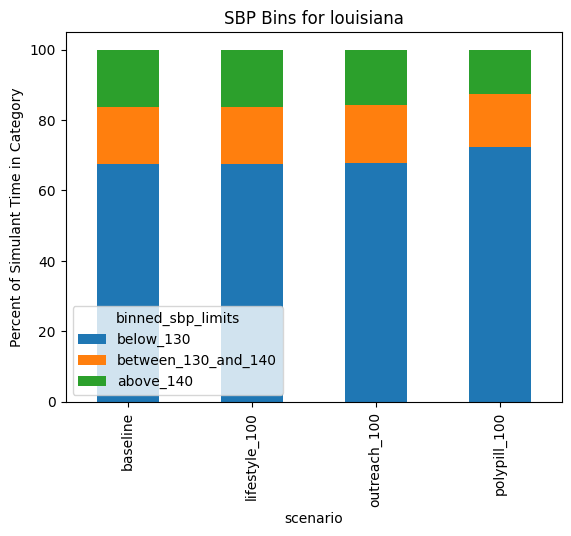

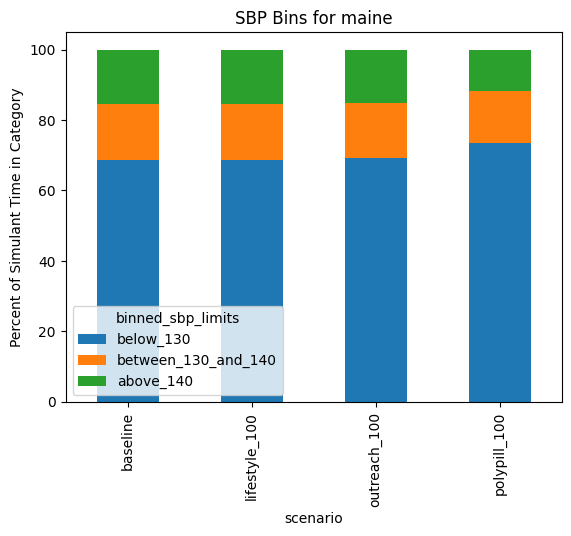

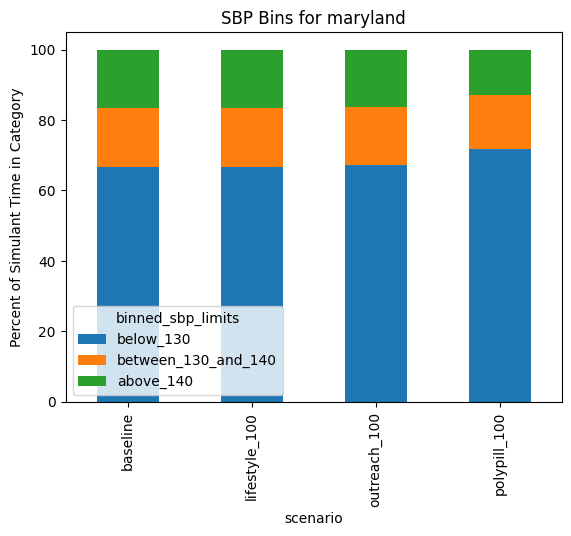

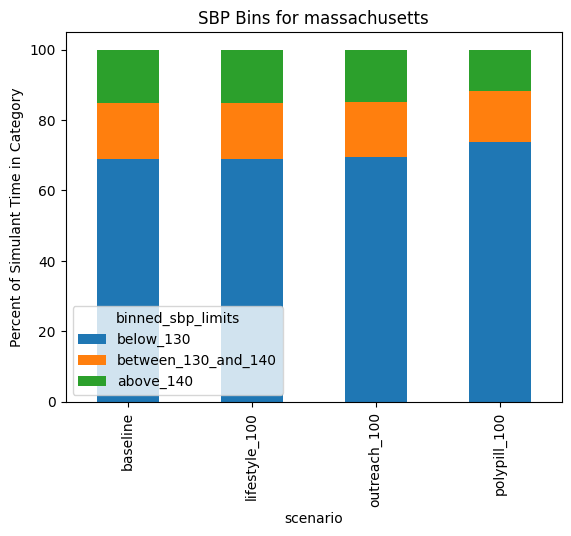

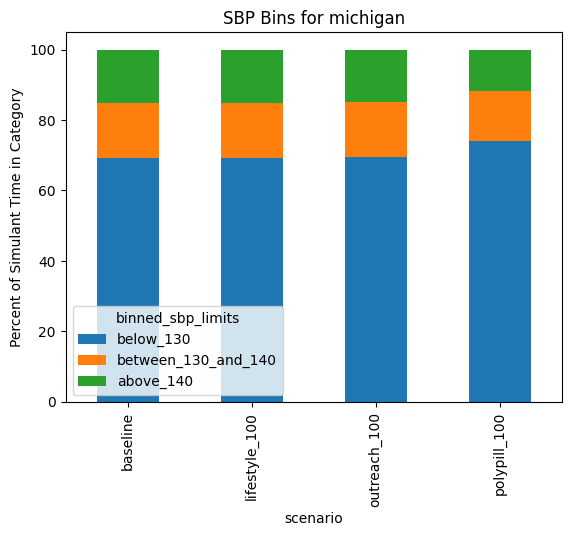

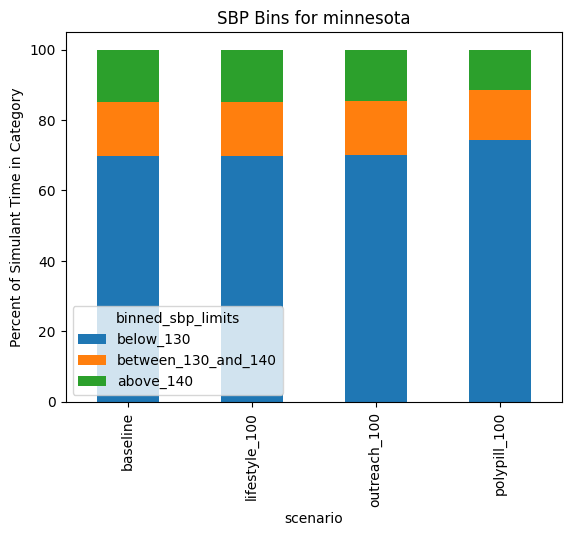

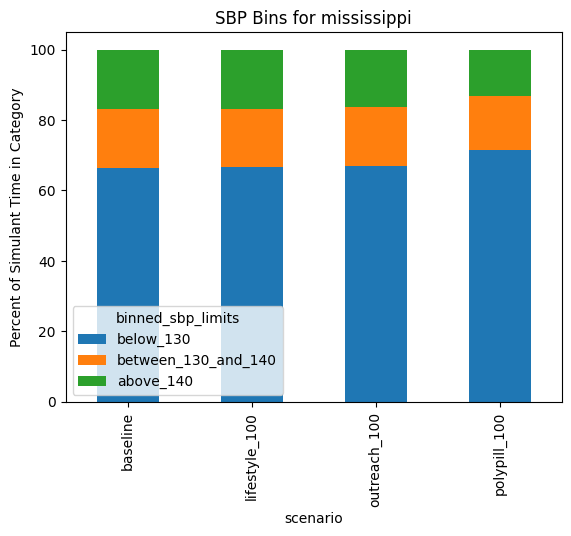

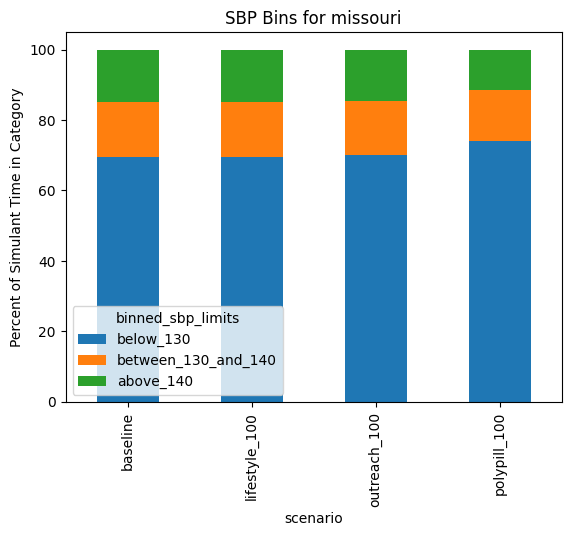

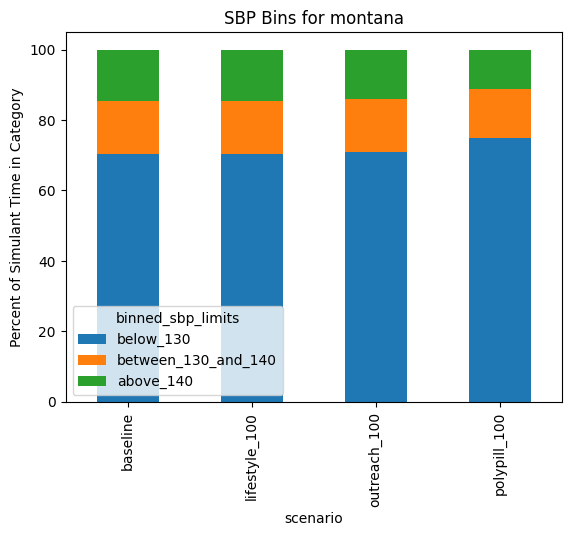

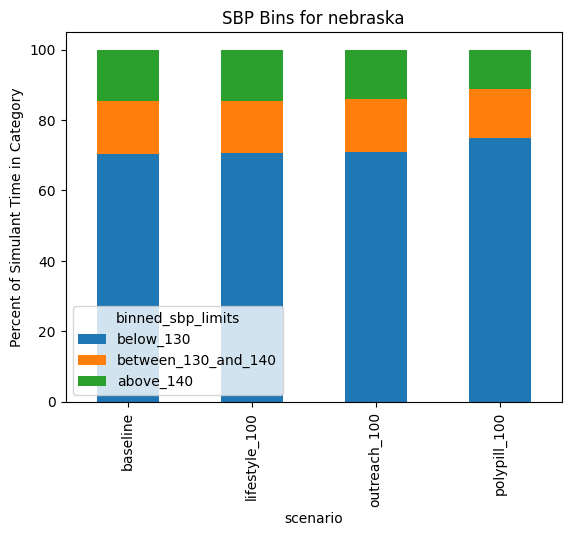

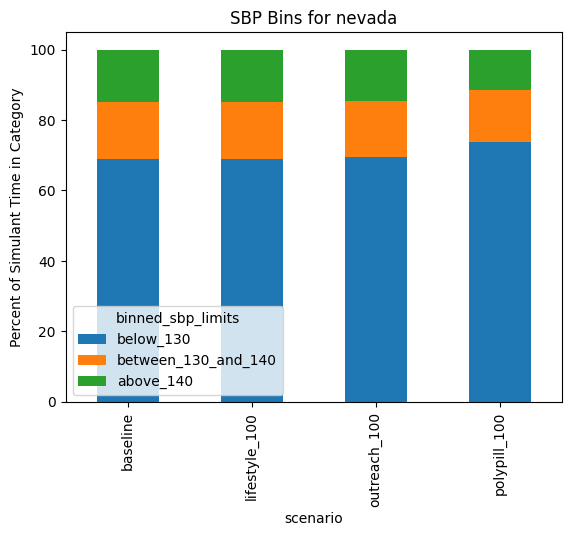

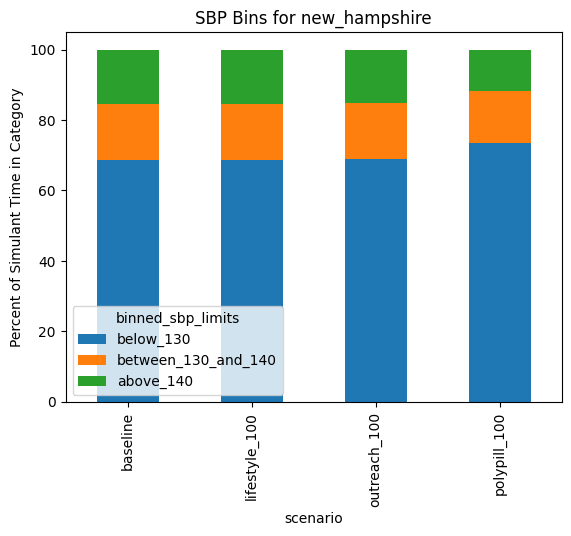

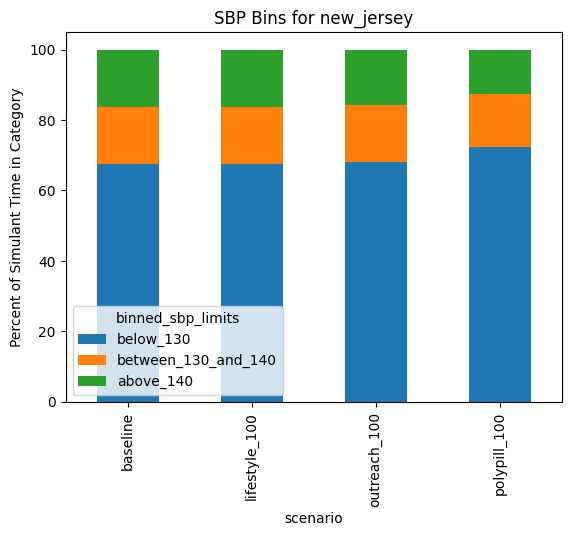

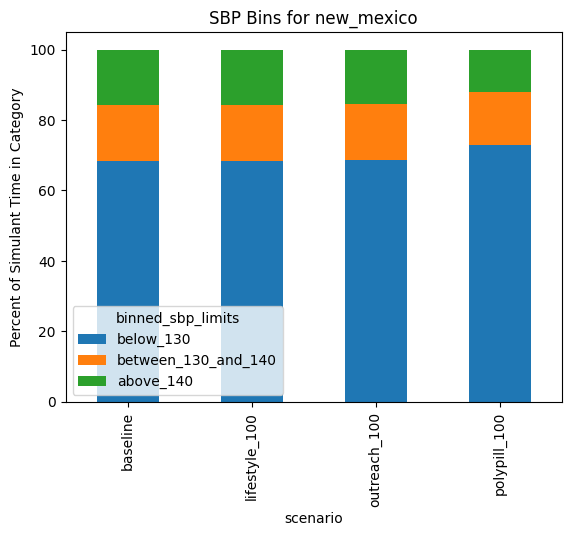

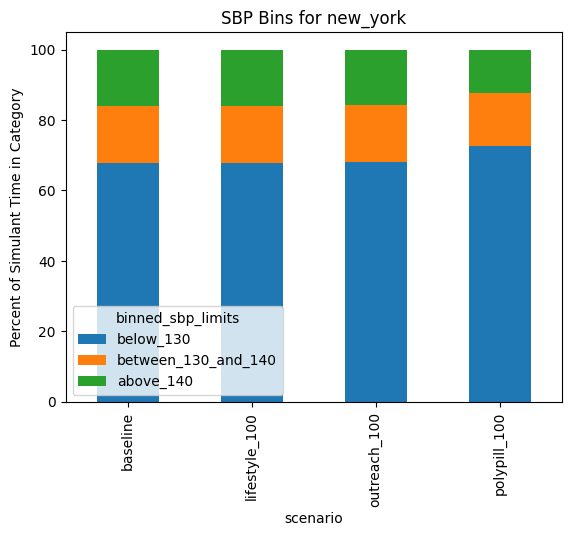

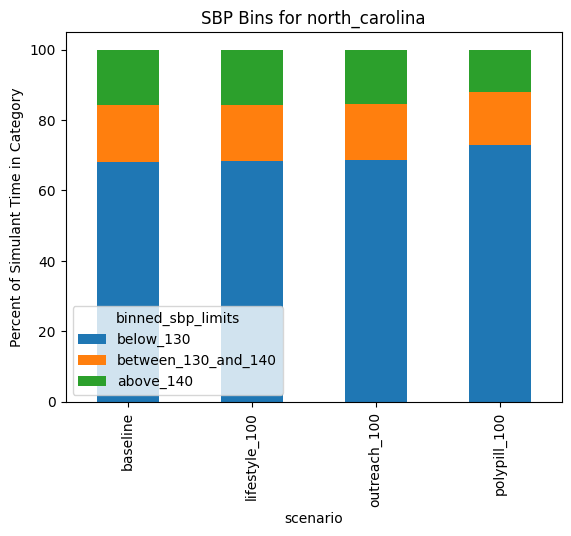

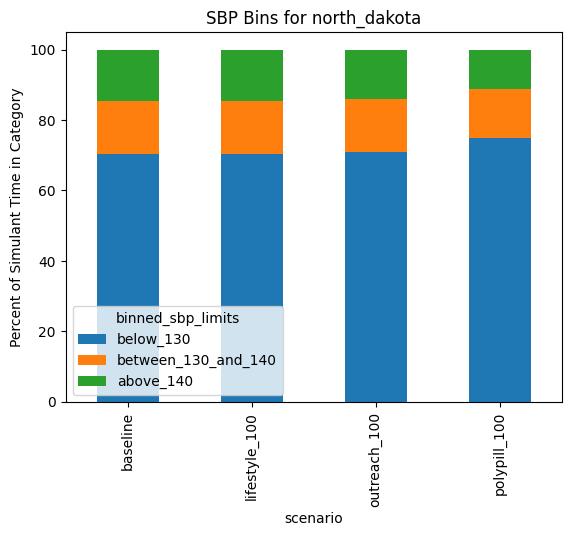

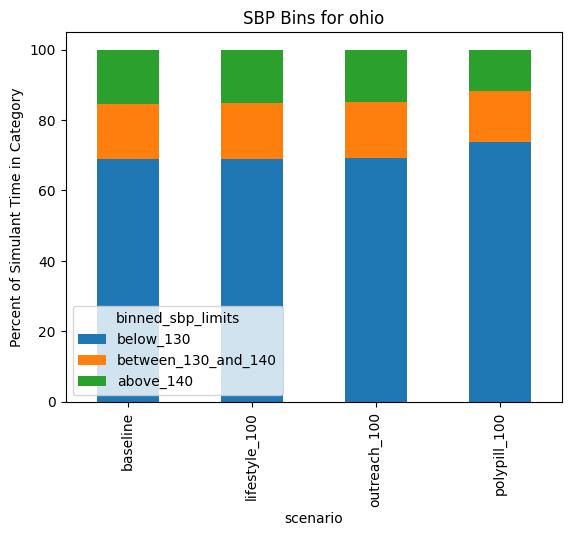

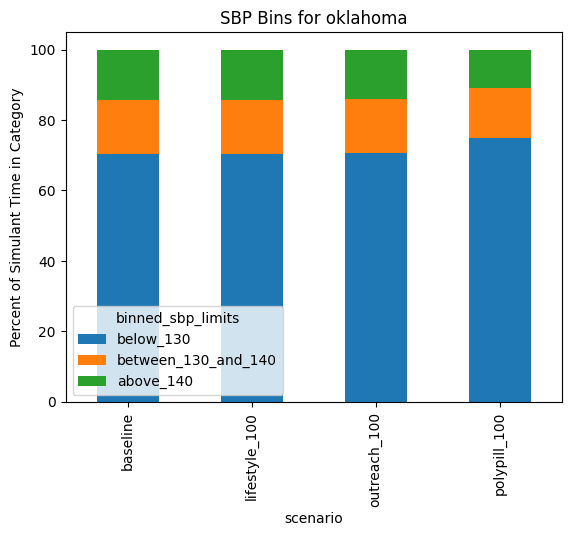

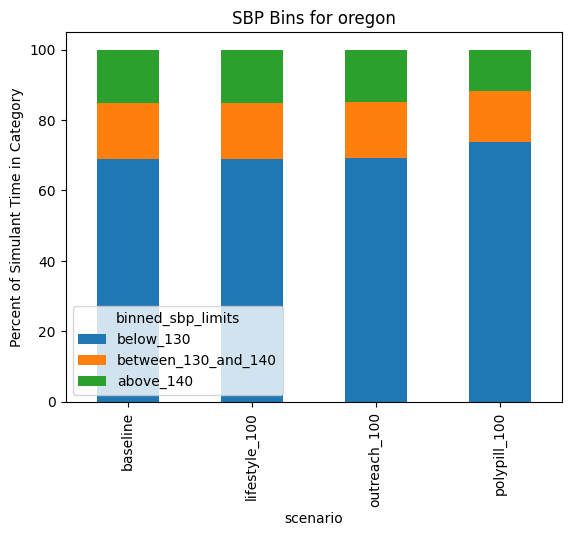

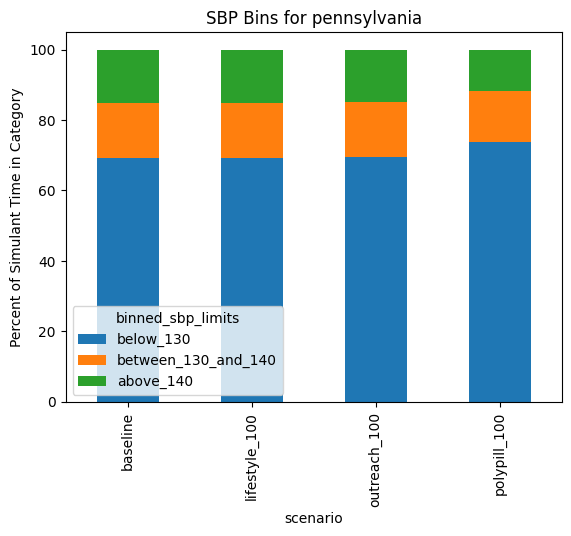

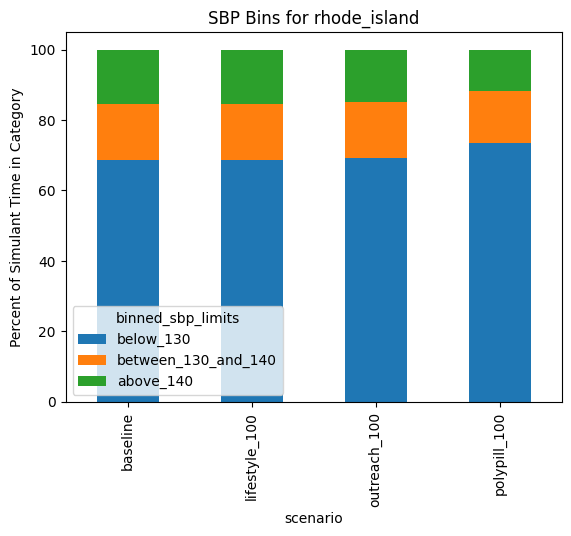

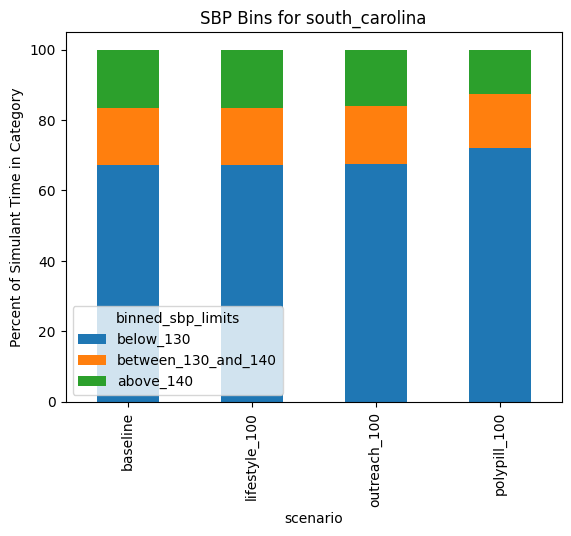

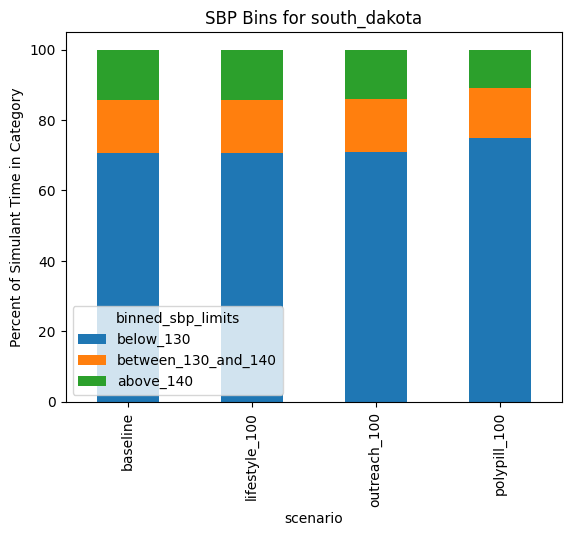

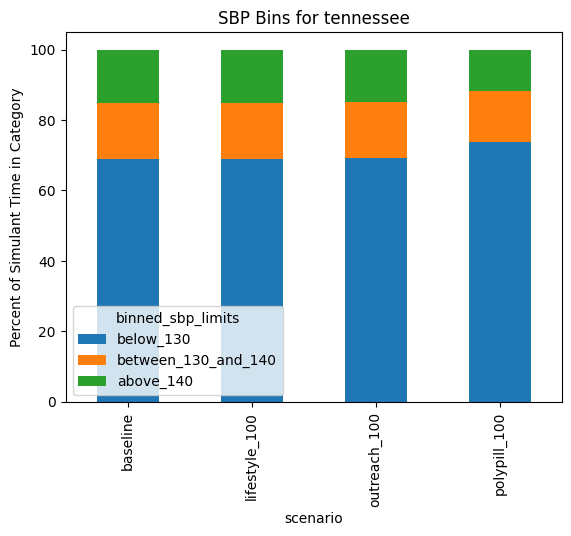

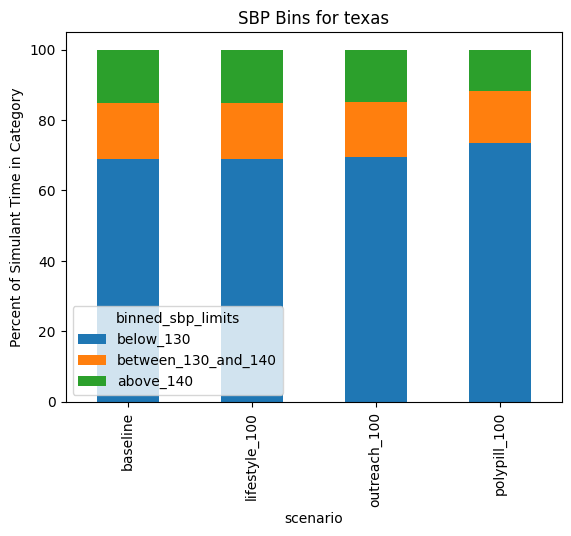

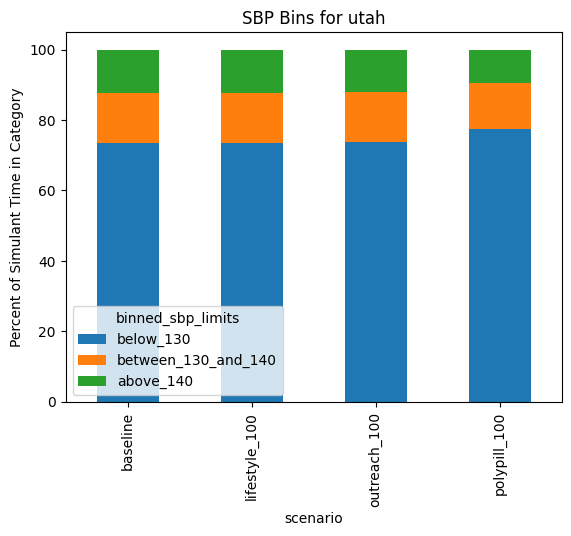

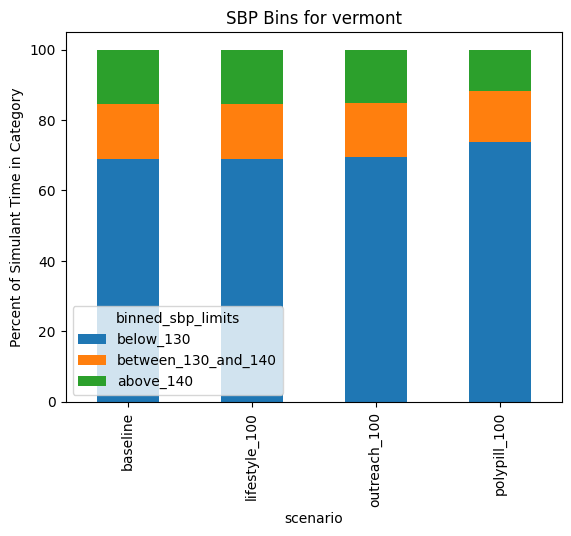

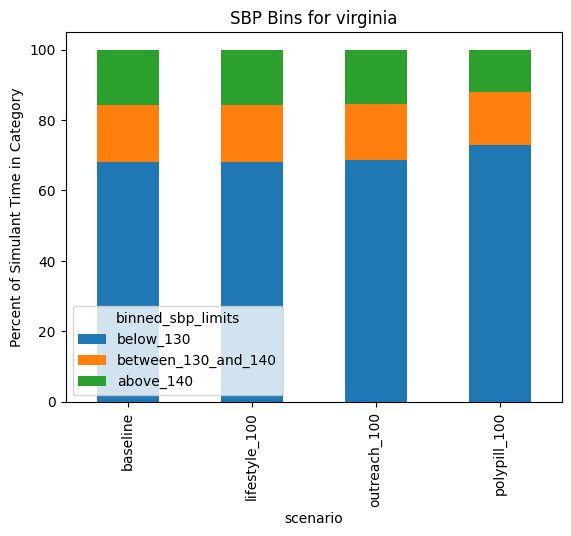

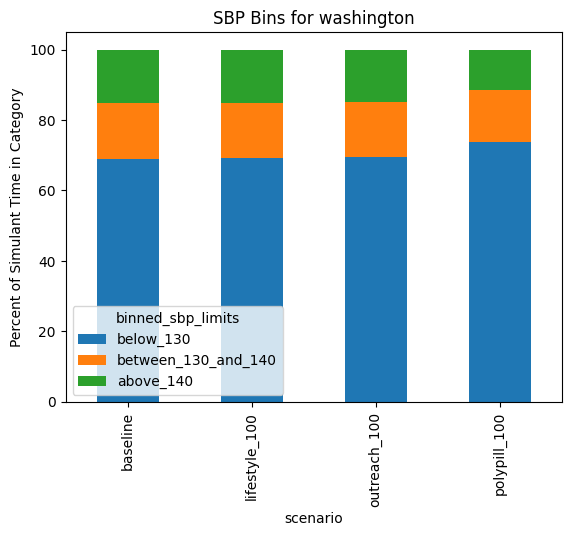

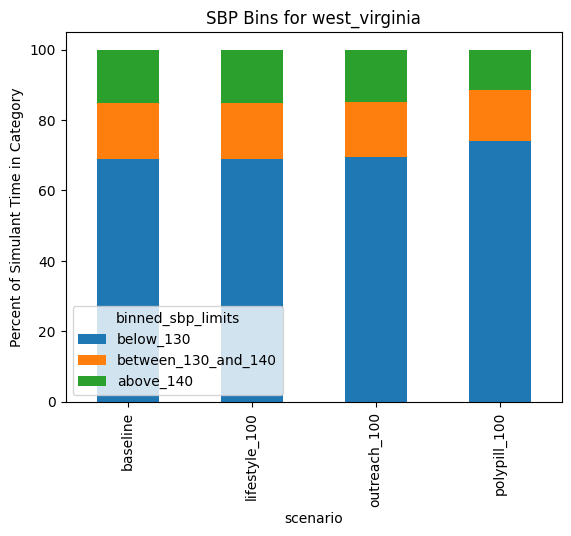

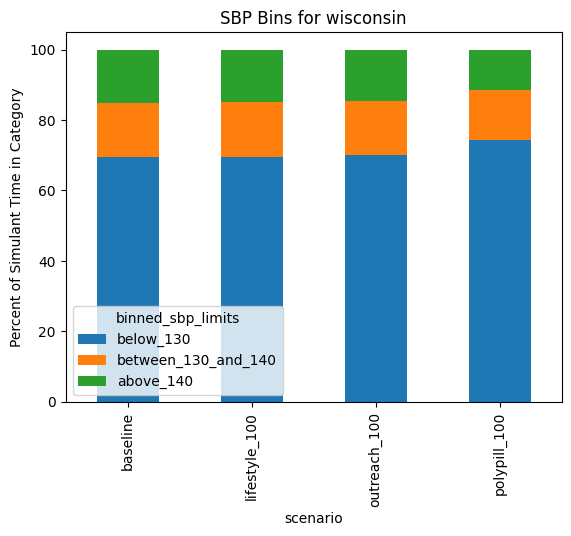

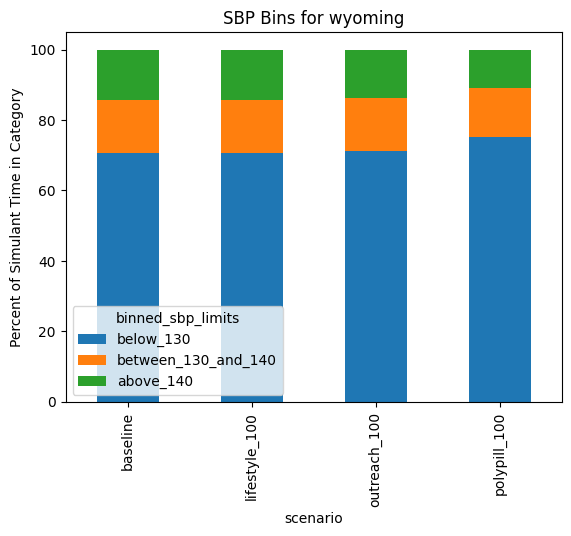

In [11]:
with PdfPages('sbp_binned_risks_8_31_23.pdf') as pdf:
    for location in binned_risks_sbp.location.unique():
        subdata = binned_risks_sbp.loc[binned_risks_sbp.location == location]
        pivot_df = subdata.pivot(index='scenario', columns='binned_sbp_limits', values='value')

        column_order = ['below_130', 'between_130_and_140', 'above_140']
        pivot_df = pivot_df[column_order]

        # Calculate the total for each category
        totals = [a+b+c for a,b,c in zip(pivot_df['below_130'], pivot_df['between_130_and_140'], pivot_df['above_140'])]

        # Normalize the data to make each category sum to 100%
        pivot_df['below_130'] = [a/total*100 for a,total in zip(pivot_df['below_130'], totals)]
        pivot_df['between_130_and_140'] = [b/total*100 for b,total in zip(pivot_df['between_130_and_140'], totals)]
        pivot_df['above_140'] = [c/total*100 for c,total in zip(pivot_df['above_140'], totals)]

        fig, ax = plt.subplots()

        pivot_df.plot(kind='bar', stacked=True, ax=ax)

        ax.set_ylabel('Percent of Simulant Time in Category')
        ax.set_title(f'SBP Bins for {location}')

        #plt.show()
        pdf.savefig(bbox_inches='tight')

In [8]:
binned_risks_ldl = pd.read_csv(sim_results_dir + 'binned_ldl_exposure_time.csv')
binned_risks_ldl = binned_risks_ldl.groupby(['year','scenario', 'binned_ldl_limits']).value.sum().reset_index()
binned_risks_ldl.head()

year  scenario      binned_ldl_limits          value
0  2021  baseline             above_4.91   51672.553046
1  2021  baseline             below_2.59  765563.389459
2  2021  baseline  between_2.59_and_3.36  640943.266256
3  2021  baseline  between_3.36_and_4.14  396231.545517
4  2021  baseline  between_4.14_and_4.91  146539.236140

In [9]:
binned_risks_sbp = pd.read_csv(sim_results_dir + 'binned_sbp_exposure_time.csv')
binned_risks_sbp = binned_risks_sbp.groupby(['year','scenario', 'binned_sbp_limits']).value.sum().reset_index()
binned_risks_sbp.head()

year       scenario    binned_sbp_limits         value
0  2021       baseline            above_140  3.231260e+05
1  2021       baseline            below_130  1.366002e+06
2  2021       baseline  between_130_and_140  3.118216e+05
3  2021  lifestyle_100            above_140  3.231260e+05
4  2021  lifestyle_100            below_130  1.366002e+06

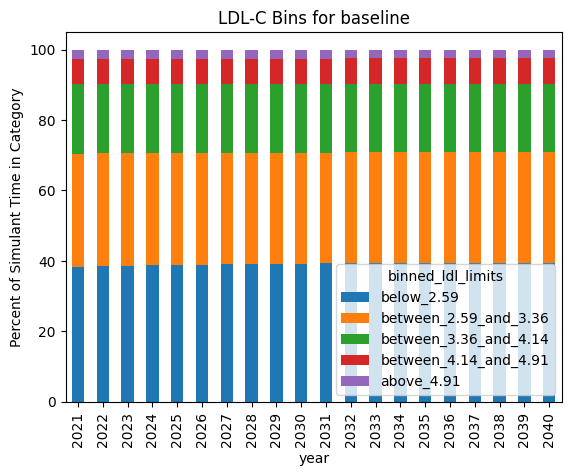

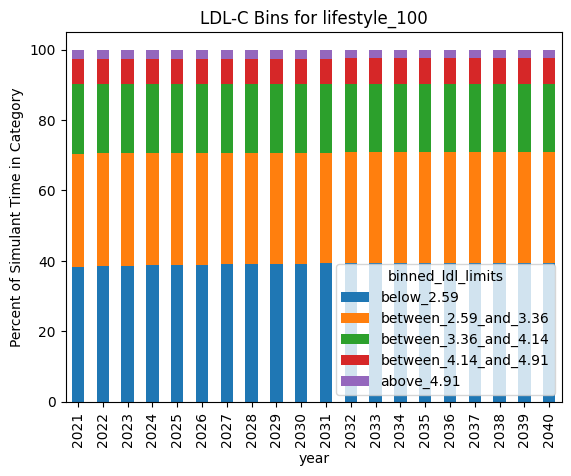

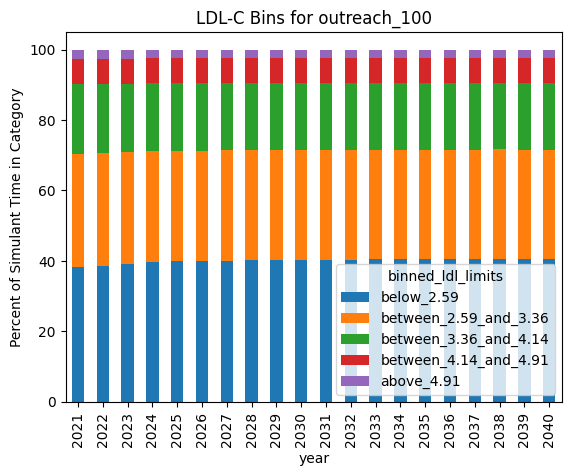

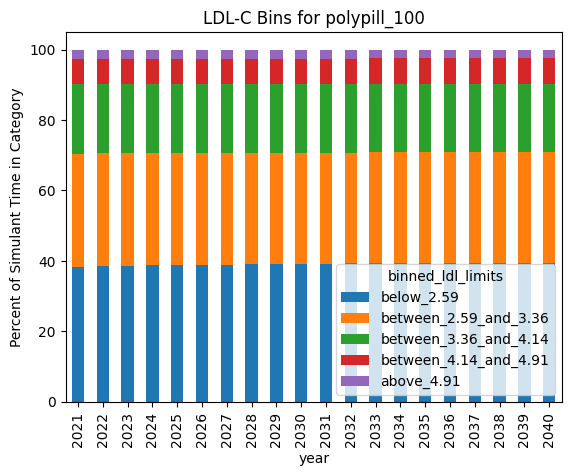

In [10]:
# Plotting
for scenario in binned_risks_ldl.scenario.unique():
    subdata = binned_risks_ldl.loc[binned_risks_ldl.scenario == scenario]
    pivot_df = subdata.pivot(index='year', columns='binned_ldl_limits', values='value')
    
    column_order = ['below_2.59', 'between_2.59_and_3.36', 'between_3.36_and_4.14', 'between_4.14_and_4.91', 'above_4.91']
    pivot_df = pivot_df[column_order]
    
    # Calculate the total for each category
    totals = [a+b+c+d+e for a,b,c,d,e in zip(pivot_df['below_2.59'], pivot_df['between_2.59_and_3.36'], pivot_df['between_3.36_and_4.14'], pivot_df['between_4.14_and_4.91'], pivot_df['above_4.91'])]

    # Normalize the data to make each category sum to 100%
    pivot_df['below_2.59'] = [a/total*100 for a,total in zip(pivot_df['below_2.59'], totals)]
    pivot_df['between_2.59_and_3.36'] = [b/total*100 for b,total in zip(pivot_df['between_2.59_and_3.36'], totals)]
    pivot_df['between_3.36_and_4.14'] = [c/total*100 for c,total in zip(pivot_df['between_3.36_and_4.14'], totals)]
    pivot_df['between_4.14_and_4.91'] = [d/total*100 for d,total in zip(pivot_df['between_4.14_and_4.91'], totals)]
    pivot_df['above_4.91'] = [e/total*100 for e,total in zip(pivot_df['above_4.91'], totals)]

    fig, ax = plt.subplots()
    
    pivot_df.plot(kind='bar', stacked=True, ax=ax)

    ax.set_ylabel('Percent of Simulant Time in Category')
    ax.set_title(f'LDL-C Bins for {scenario}')

    plt.show()

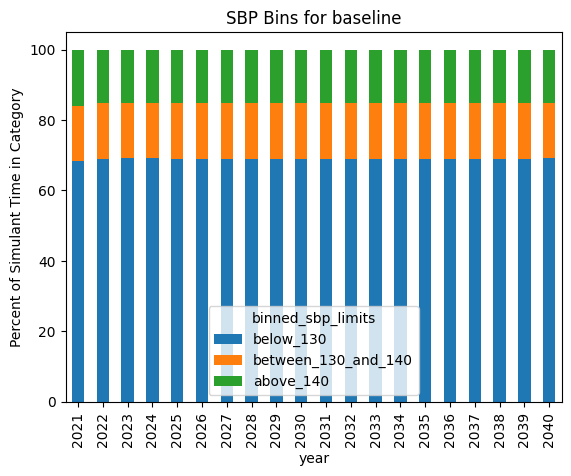

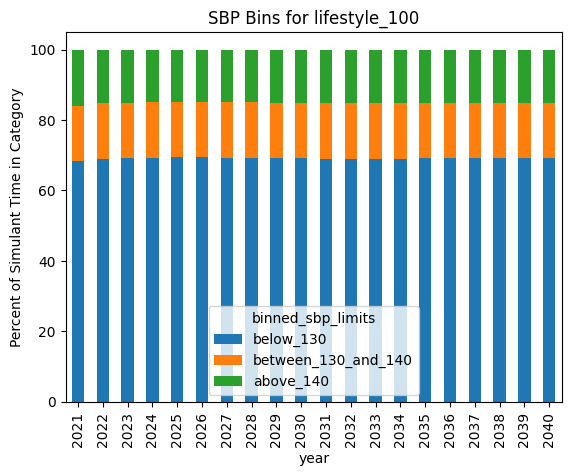

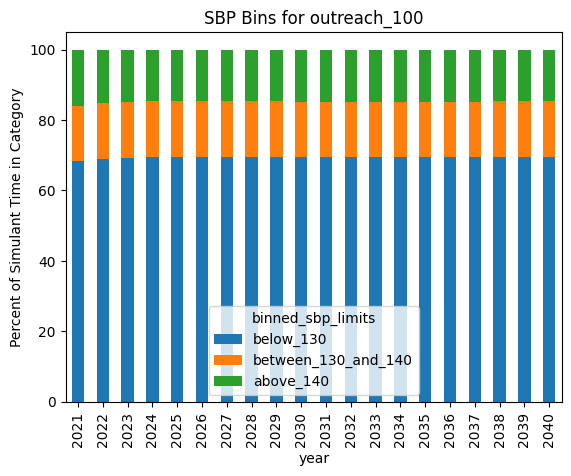

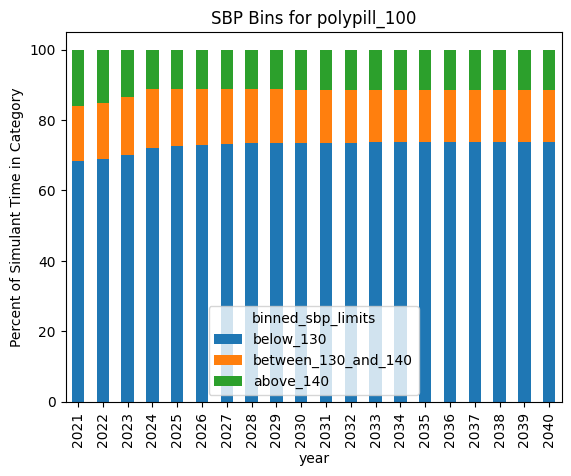

In [11]:
# Plotting
for scenario in binned_risks_sbp.scenario.unique():
    subdata = binned_risks_sbp.loc[binned_risks_sbp.scenario == scenario]
    pivot_df = subdata.pivot(index='year', columns='binned_sbp_limits', values='value')
    
    column_order = ['below_130', 'between_130_and_140', 'above_140']
    pivot_df = pivot_df[column_order]

    # Calculate the total for each category
    totals = [a+b+c for a,b,c in zip(pivot_df['below_130'], pivot_df['between_130_and_140'], pivot_df['above_140'])]

    # Normalize the data to make each category sum to 100%
    pivot_df['below_130'] = [a/total*100 for a,total in zip(pivot_df['below_130'], totals)]
    pivot_df['between_130_and_140'] = [b/total*100 for b,total in zip(pivot_df['between_130_and_140'], totals)]
    pivot_df['above_140'] = [c/total*100 for c,total in zip(pivot_df['above_140'], totals)]

    fig, ax = plt.subplots()

    pivot_df.plot(kind='bar', stacked=True, ax=ax)

    ax.set_ylabel('Percent of Simulant Time in Category')
    ax.set_title(f'SBP Bins for {scenario}')

    plt.show()

## Some math for tables:

In [12]:
grouped_data = binned_risks_ldl.groupby(['scenario', 'binned_ldl_limits']).value.sum().reset_index()
pivot_df = grouped_data.pivot(index='scenario', columns='binned_ldl_limits', values='value')

column_order = ['below_2.59', 'between_2.59_and_3.36', 'between_3.36_and_4.14', 'between_4.14_and_4.91', 'above_4.91']
pivot_df = pivot_df[column_order]

# Calculate the total for each category
totals = [a+b+c+d+e for a,b,c,d,e in zip(pivot_df['below_2.59'], pivot_df['between_2.59_and_3.36'], pivot_df['between_3.36_and_4.14'], pivot_df['between_4.14_and_4.91'], pivot_df['above_4.91'])]

# Normalize the data to make each category sum to 100%
pivot_df['below_2.59'] = [a/total*100 for a,total in zip(pivot_df['below_2.59'], totals)]
pivot_df['between_2.59_and_3.36'] = [b/total*100 for b,total in zip(pivot_df['between_2.59_and_3.36'], totals)]
pivot_df['between_3.36_and_4.14'] = [c/total*100 for c,total in zip(pivot_df['between_3.36_and_4.14'], totals)]
pivot_df['between_4.14_and_4.91'] = [d/total*100 for d,total in zip(pivot_df['between_4.14_and_4.91'], totals)]
pivot_df['above_4.91'] = [e/total*100 for e,total in zip(pivot_df['above_4.91'], totals)]

pivot_df.reset_index(inplace=True)

In [13]:
print(pivot_df.loc[pivot_df.scenario=='outreach_100','below_2.59'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','below_2.59'].values[0])

print(pivot_df.loc[pivot_df.scenario=='outreach_100','between_2.59_and_3.36'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','between_2.59_and_3.36'].values[0])

print(pivot_df.loc[pivot_df.scenario=='outreach_100','between_3.36_and_4.14'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','between_3.36_and_4.14'].values[0])

print(pivot_df.loc[pivot_df.scenario=='outreach_100','between_4.14_and_4.91'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','between_4.14_and_4.91'].values[0])

print(pivot_df.loc[pivot_df.scenario=='outreach_100','above_4.91'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','above_4.91'].values[0])

0.9115287503057914
-0.2805171820257186
-0.4060803388610168
-0.16645765275474478
-0.0584735766642952


In [14]:
pivot_df.loc[pivot_df.scenario=='outreach_100','below_2.59'].values[0]

40.02447439638655

In [15]:
pivot_df.loc[pivot_df.scenario=='baseline','below_2.59'].values[0]

39.11294564608076

### SBP

In [16]:
grouped_data = binned_risks_sbp.groupby(['scenario', 'binned_sbp_limits']).value.sum().reset_index()
pivot_df = grouped_data.pivot(index='scenario', columns='binned_sbp_limits', values='value')

column_order = ['below_130', 'between_130_and_140', 'above_140']
pivot_df = pivot_df[column_order]

# Calculate the total for each category
totals = [a+b+c for a,b,c in zip(pivot_df['below_130'], pivot_df['between_130_and_140'], pivot_df['above_140'])]

# Normalize the data to make each category sum to 100%
pivot_df['below_130'] = [a/total*100 for a,total in zip(pivot_df['below_130'], totals)]
pivot_df['between_130_and_140'] = [b/total*100 for b,total in zip(pivot_df['between_130_and_140'], totals)]
pivot_df['above_140'] = [c/total*100 for c,total in zip(pivot_df['above_140'], totals)]

pivot_df.reset_index(inplace=True)
pivot_df

binned_sbp_limits       scenario  below_130  between_130_and_140  above_140
0                       baseline  68.958806            15.849244  15.191950
1                  lifestyle_100  69.106683            15.779264  15.114053
2                   outreach_100  69.387780            15.765805  14.846415
3                   polypill_100  72.808659            15.275365  11.915976

In [17]:
print(pivot_df.loc[pivot_df.scenario=='lifestyle_100','below_130'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','below_130'].values[0])

print(pivot_df.loc[pivot_df.scenario=='lifestyle_100','between_130_and_140'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','between_130_and_140'].values[0])

print(pivot_df.loc[pivot_df.scenario=='lifestyle_100','above_140'].values[0] - 
      pivot_df.loc[pivot_df.scenario=='baseline','above_140'].values[0])

0.14787701523660246
-0.0699802028255867
-0.07789681241101931


In [18]:
pivot_df.loc[pivot_df.scenario=='lifestyle_100','below_130'].values[0]

69.1066827416596

In [19]:
pivot_df.loc[pivot_df.scenario=='baseline','below_130'].values[0]

68.958805726423

## Intervention Person Time

In [25]:
intervention_time = pd.read_csv(sim_results_dir + 'intervention_person_time.csv')
intervention_time = intervention_time.loc[intervention_time.year == 2040]
intervention_time = intervention_time.groupby(['scenario','intervention_type','intervention']).value.sum().reset_index()
intervention_time_yes = intervention_time.groupby(['scenario','intervention_type']).value.sum().reset_index()
intervention_time_all = intervention_time.merge(intervention_time_yes[['scenario','intervention_type','value']],on=['scenario','intervention_type'])
intervention_time_all['rate'] = intervention_time_all.value_x / intervention_time_all.value_y
intervention_time_all

scenario intervention_type intervention       value_x       value_y  \
0        baseline         lifestyle           no  1.876140e+06  1.922038e+06   
1        baseline         lifestyle          yes  4.589731e+04  1.922038e+06   
2        baseline          outreach           no  1.922038e+06  1.922038e+06   
3        baseline          outreach          yes  0.000000e+00  1.922038e+06   
4        baseline          polypill           no  1.922038e+06  1.922038e+06   
5        baseline          polypill          yes  0.000000e+00  1.922038e+06   
6   lifestyle_100         lifestyle           no  1.403309e+06  1.923253e+06   
7   lifestyle_100         lifestyle          yes  5.199440e+05  1.923253e+06   
8   lifestyle_100          outreach           no  1.923253e+06  1.923253e+06   
9   lifestyle_100          outreach          yes  0.000000e+00  1.923253e+06   
10  lifestyle_100          polypill           no  1.923253e+06  1.923253e+06   
11  lifestyle_100          polypill          yes  0.000000e+00  1.923253e+06   
12   outreach_100         lifestyle           no  1.877285e+06  1.923207e+06   
13   outreach_100         lifestyle          yes  4.592199e+04  1.923207e+06   
14   outreach_100          outreach           no  1.121598e+06  1.923207e+06   
15   outreach_100          outreach          yes  8.016091e+05  1.923207e+06   
16   outreach_100          polypill           no  1.923207e+06  1.923207e+06   
17   outreach_100          polypill          yes  0.000000e+00  1.923207e+06   
18   polypill_100         lifestyle           no  1.883271e+06  1.929385e+06   
19   polypill_100         lifestyle          yes  4.611357e+04  1.929385e+06   
20   polypill_100          outreach           no  1.929385e+06  1.929385e+06   
21   polypill_100          outreach          yes  0.000000e+00  1.929385e+06   
22   polypill_100          polypill           no  1.590293e+06  1.929385e+06   
23   polypill_100          polypill          yes  3.390915e+05  1.929385e+06   

        rate  
0   0.976120  
1   0.023880  
2   1.000000  
3   0.000000  
4   1.000000  
5   0.000000  
6   0.729654  
7   0.270346  
8   1.000000  
9   0.000000  
10  1.000000  
11  0.000000  
12  0.976122  
13  0.023878  
14  0.583191  
15  0.416809  
16  1.000000  
17  0.000000  
18  0.976099  
19  0.023901  
20  1.000000  
21  0.000000  
22  0.824249  
23  0.175751